In [1]:
#------------------------------------------------------------------------------------------------------------------------------------------
# basic setup of the notebook
#------------------------------------------------------------------------------------------------------------------------------------------
import numpy as np
import math
import timeit
import time
import sys
from pip._vendor import tomli
sys.path.append('../code')
from fit_drivers import *
from minimizer import *
from fit_functions import *
from output_functions import *
from general_stats import *
from jpac_colors import *
import fit_drivers, minimizer, fit_functions, output_functions, general_stats 

# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit
from iminuit import minimize
from iminuit.util import describe
from typing import Annotated
from jpac_colors import *

# display iminuit version
import iminuit
print("iminuit version:", iminuit.__version__)

from matplotlib import pyplot as plt
plt.style.use('coulomb')
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

import matplotlib.ticker as ticker
from matplotlib.ticker import StrMethodFormatter, NullFormatter

iminuit version: 2.28.0


In [2]:
#------------------------------------------------------------------------------------------------------------------------------------------
# Importing fixed params for analysis
#------------------------------------------------------------------------------------------------------------------------------------------
lattice_sizes=[16,24,32]

f_data_ratios=[]
f_data_ratios_err=[]
f_data_Wilson=[]
f_data_Wilson_err=[]
f_data_Coulomb=[]
f_data_Coulomb_err=[]
xirun=[]

for l in range(len(lattice_sizes)):

    xirun_int=[]
    betarun=[]
    betax=[]

    file=['../ini_files/S_analysis_L{}_pole.toml'.format(lattice_sizes[l]),'../ini_files/S_analysis_WL_L{}_xi=1.toml'.format(lattice_sizes[l])]
    file_basic=['../ini_files/basic_setup_pole.toml','../ini_files/basic_setup.toml']

    data_f=[]
    edata_f=[]
    dini_Gc=[]
    dstop_Gc=[]
    for x in range(len(file)):
        with open("{}".format(file[x]), "rb") as f:
            params = tomli.load(f)

        with open("{}".format(file_basic[x]), "rb") as f2:
            params2 = tomli.load(f2)

        for i in params:
            params['{}'.format(i)].update(params2['{}'.format(i)])


        who            = params['creator']['who']


        path           = params['paths_to_files']['base_path']
        mainpath       = '{}{}'.format(path,params['paths_to_files']['mainpath'])
        resultspath    = '{}{}'.format(path,params['paths_to_files']['resultspath'])
        resultsdir     = '{}{}'.format(path,params['paths_to_files']['resultsdir'])
        plotsdir       = '{}{}'.format(path,params['paths_to_files']['plotsdir'])
        Gcplotsdir     = '{}{}'.format(path,params['paths_to_files']['Gcplotsdir'])
        sizelabel      = params['paths_to_files']['sizelabel']      


        corrtype       = params['correlators']['corrtype']
        xi             = params['correlators']['xi']
        beta           = params['correlators']['beta']
        betanorm       = params['correlators']['betanorm']
        Lextent        = params['correlators']['Lextent']
        Textent        = params['correlators']['Textent']
        size           = params['correlators']['size']
        Ncfgs          = params['correlators']['Ncfgs']


        dini_Gc        .append( params['minimization_parameters']['dini_Gc'])
        dstop_Gc       .append( params['minimization_parameters']['dstop_Gc'])
        dmindata_Gc    = params['minimization_parameters']['dmindata_Gc']
        dini_Vr        = params['minimization_parameters']['dini_Vr']
        dstop_Vr       = params['minimization_parameters']['dstop_Vr']
        dmindata_Vr    = params['minimization_parameters']['dmindata_Vr']
        dfin_Gc        = params['minimization_parameters']['dfin_Gc']
        dfin_Vr        = params['minimization_parameters']['dfin_Vr']
        reuse          = params['minimization_parameters']['reuse']
        inv_first      = params['minimization_parameters']['inv_first']
        mcalls         = params['minimization_parameters']['mcalls']
        mtol           = params['minimization_parameters']['mtol']
        inipars_Gc     = params['minimization_parameters']['inipars_GC']
        variants_Gc    = params['minimization_parameters']['variants_GC']
        jackkl         = params['minimization_parameters']['jackkl']
        xiini          = params['minimization_parameters']['xiini']
        xifin          = params['minimization_parameters']['xifin']   
        fileini        = params['minimization_parameters']['fileini']                         
        filefin        = params['minimization_parameters']['filefin']
        datatype_Gc    = params['minimization_parameters']['datatype_Gc']
        model_Gc       = params['minimization_parameters']['model_Gc']
        model_Vr       = params['minimization_parameters']['model_Vr']
        datatype_Vr    = params['minimization_parameters']['datatype_Vr']
        inipars_Vr     = params['minimization_parameters']['inipars_Vr']
        variants_Vr    = params['minimization_parameters']['variants_Vr']
        multiprocess   = params['minimization_parameters']['multiprocess']
        improve        = params['minimization_parameters']['improve']
        multistart     = params['minimization_parameters']['multistart']   
        cov_freeze     = params['minimization_parameters']['cov_freeze'] 

        clean          = params['extra']['clean']
        cutoff_ma      = params['extra']['cutoff_ma']
        no_corrs       = params['extra']['no_corrs']
        no_valid_check = params['extra']['no_valid_check']

        als            = params['correlators']['als']

        filefin=7

        signorm=0.44**2
           # Copy pasted from Sebastian's slack table (they do not correspond to this lattices!! It is just a sloppy calc)
        if (x==0):
            xirun_int.append(xi[xiini:xifin+1])

        betarun.append(beta[fileini:filefin+1])

        #variants_Gc=['single','double']

        # Data used in the analysis
        data_int=[]
        edata_int=[]    
        alsx=[]
        betax.append(np.array(betarun[x])/betanorm)
        for k in range(len(xi)):
            data_int_int=[]
            edata_int_int=[]
            for j in range(len(betarun[x])):
                alsx.append(als[k][j])
                print('../{}{}/{}_{}_{}_sigma_ti{}_{}_tfin{}_tmin{}_rmin{}_{}_rfin{}_beta={}_nocorrs={}_{}.dat'.format(resultspath,xi[k],len(variants_Gc),model_Gc,datatype_Gc,dini_Gc[x],dstop_Gc[x],dfin_Gc,dmindata_Gc,dini_Vr,dstop_Vr,dfin_Vr,betarun[x][j],no_corrs,corrtype))
                data_int_int.append(np.loadtxt('../{}{}/{}_{}_{}_sigma_ti{}_{}_tfin{}_tmin{}_rmin{}_{}_rfin{}_beta={}_nocorrs={}_{}.dat'.format(resultspath,xi[k],len(variants_Gc),model_Gc,datatype_Gc,dini_Gc[x],dstop_Gc[x],dfin_Gc,dmindata_Gc,dini_Vr,dstop_Vr,dfin_Vr,betarun[x][j],no_corrs,corrtype))[0]*xi[k]/als[k][j]**2)
                edata_int_int.append(np.loadtxt('../{}{}/{}_{}_{}_sigma_ti{}_{}_tfin{}_tmin{}_rmin{}_{}_rfin{}_beta={}_nocorrs={}_{}.dat'.format(resultspath,xi[k],len(variants_Gc),model_Gc,datatype_Gc,dini_Gc[x],dstop_Gc[x],dfin_Gc,dmindata_Gc,dini_Vr,dstop_Vr,dfin_Vr,betarun[x][j],no_corrs,corrtype))[1]*xi[k]/als[k][j]**2)
            data_int.append(data_int_int)
            edata_int.append(edata_int_int)
            
        data_f.append(data_int)
        edata_f.append(edata_int)
    
    xilen=len(xirun_int[0])
    betalen=len(betarun[0])
    
    
    data_ratios     = []
    data_ratios_err = []
    data_Wilson     = []
    data_Wilson_err = []
    data_Coulomb     = []
    data_Coulomb_err = []    


    for k in range(xilen):
        data_ratios_int     = []
        data_ratios_err_int = []
        data_Wilson_int     = []
        data_Wilson_err_int = []
        data_Coulomb_int     = []
        data_Coulomb_err_int = []
        for j in range(betalen):
            avg_Coulomb=data_f[0][k][j]
            avg_Wilson=data_f[1][0][j]
            data_Wilson_int.append(avg_Wilson)
            data_Coulomb_int.append(avg_Coulomb)
            data_ratios_int.append(avg_Coulomb/avg_Wilson)
            err_Coul=edata_f[0][k][j]
            err_Wilson=edata_f[1][0][j]
            data_Wilson_err_int.append(err_Wilson)
            data_Coulomb_err_int.append(err_Coul)
            data_ratios_err_int.append(np.sqrt((err_Coul/avg_Wilson)**2+(avg_Coulomb/avg_Wilson**2*err_Wilson)**2))
            
        data_ratios.append(data_ratios_int)  
        data_ratios_err.append(data_ratios_err_int)
        data_Wilson.append(data_Wilson_int)  
        data_Wilson_err.append(data_Wilson_err_int)
        data_Coulomb.append(data_Coulomb_int)  
        data_Coulomb_err.append(data_Coulomb_err_int)

    f_data_ratios.append(data_ratios)
    f_data_ratios_err.append(data_ratios_err)
    f_data_Wilson.append(data_Wilson)
    f_data_Wilson_err.append(data_Wilson_err)
    f_data_Coulomb.append(data_Coulomb)
    f_data_Coulomb_err.append(data_Coulomb_err)

    xirun.append(xirun_int)

gev_m1_tofm=5.068
xirun

../../S_correlators_L16/results/xi=1/3_nb_exp_np_pole_exp_sigma_ti1_0_tfin100_tmin6_rmin1_2_rfin6_beta=225_nocorrs=0_g.dat
../../S_correlators_L16/results/xi=1/3_nb_exp_np_pole_exp_sigma_ti1_0_tfin100_tmin6_rmin1_2_rfin6_beta=230_nocorrs=0_g.dat
../../S_correlators_L16/results/xi=1/3_nb_exp_np_pole_exp_sigma_ti1_0_tfin100_tmin6_rmin1_2_rfin6_beta=235_nocorrs=0_g.dat
../../S_correlators_L16/results/xi=1/3_nb_exp_np_pole_exp_sigma_ti1_0_tfin100_tmin6_rmin1_2_rfin6_beta=240_nocorrs=0_g.dat
../../S_correlators_L16/results/xi=1/3_nb_exp_np_pole_exp_sigma_ti1_0_tfin100_tmin6_rmin1_2_rfin6_beta=245_nocorrs=0_g.dat
../../S_correlators_L16/results/xi=1/3_nb_exp_np_pole_exp_sigma_ti1_0_tfin100_tmin6_rmin1_2_rfin6_beta=250_nocorrs=0_g.dat
../../S_correlators_L16/results/xi=1/3_nb_exp_np_pole_exp_sigma_ti1_0_tfin100_tmin6_rmin1_2_rfin6_beta=255_nocorrs=0_g.dat
../../S_correlators_L16/results/xi=1/3_nb_exp_np_pole_exp_sigma_ti1_0_tfin100_tmin6_rmin1_2_rfin6_beta=260_nocorrs=0_g.dat
../../S_correlat

[[[1, 2, 3, 4, 5]], [[1, 2, 3, 4, 5, 6, 7, 8]], [[1, 2, 3, 4]]]

0.4581126177248503 0.024170044146887948
0.45874978098390123 0.024136474072877234


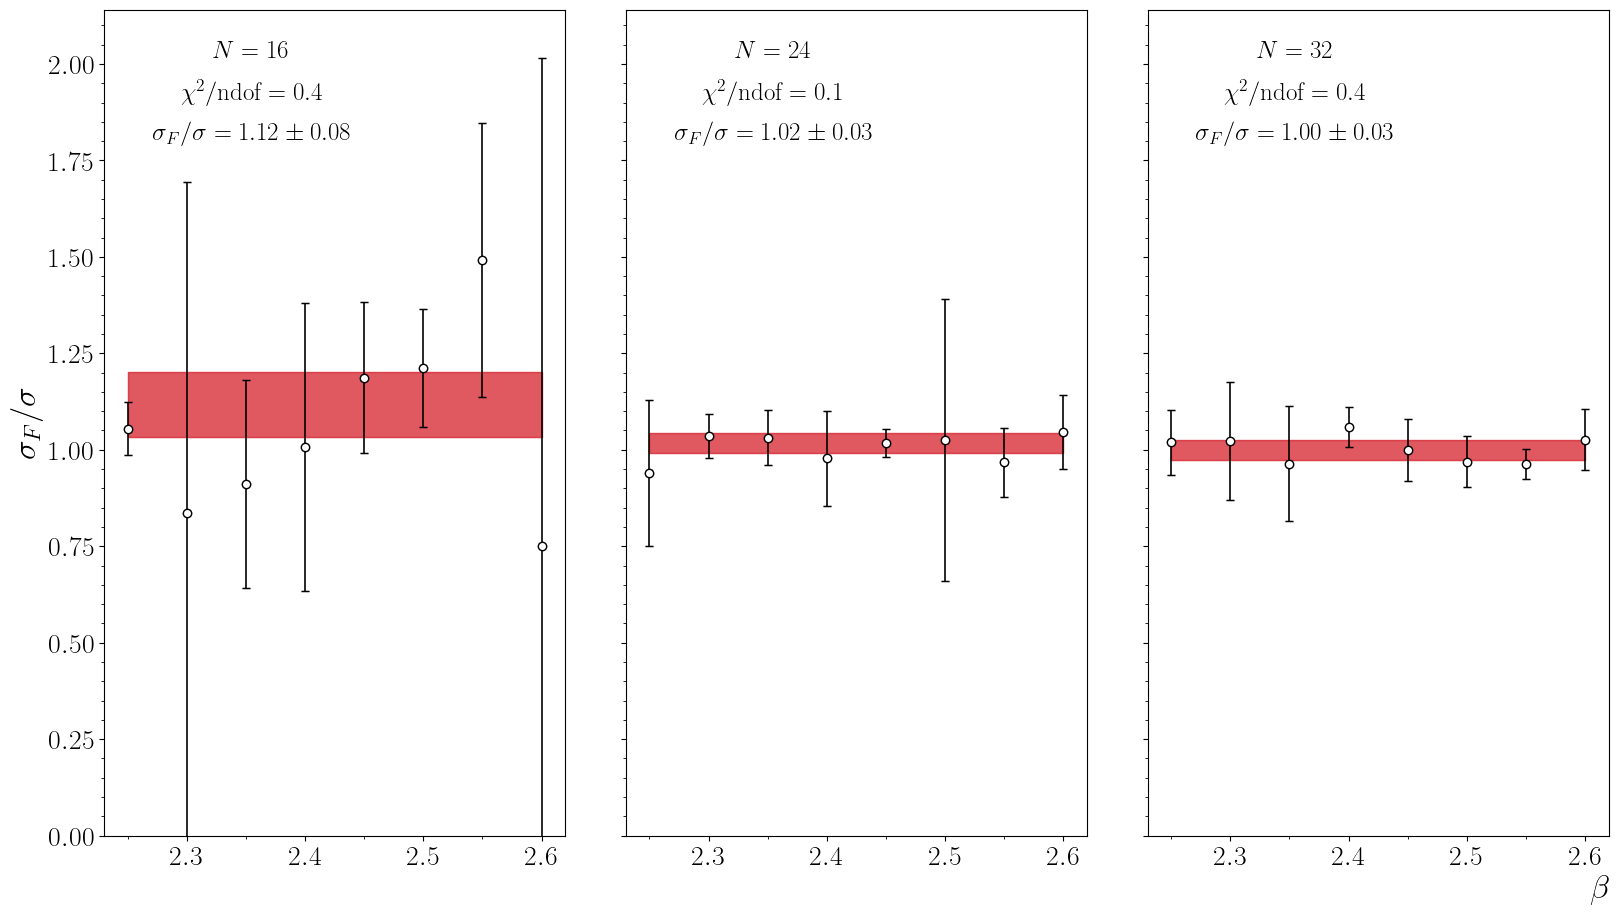

In [3]:
#Plot sigma for beta
inipars=[[2]]
variants=[['c']]

dini=1
dstop=12
dmindata=6
dfin=100

model=line_np
datatytep="log"

model='line_np'
datatype='ratio'

fig, axs = plt.subplots(1, 3,figsize=(16,9), sharex='col', sharey='row')
fig.tight_layout()

envelope=[]
for l in range(len(lattice_sizes)):

    data_y   = np.array(f_data_Wilson[l][0])/signorm
    data_err = np.array(f_data_Wilson_err[l][0])/signorm

    lt=len(data_y)
    data_t   = betax[1]

    data_cov = np.zeros((lt,lt))
    for i in range(lt):
        data_cov[i,i]=data_err[i]**2


    m=Modelsmin( data_t, data_y, data_cov, dini, dstop, dmindata, dfin, inipars, model, variants, datatype, mcalls, mtol, reuse, inv_first, 10, cov_freeze, improve,100,no_corrs,no_valid_check)

    mf=m.minimize()
    AIC_list=AIClist(mf[1])

    data_tf  = np.linspace(data_t[0],data_t[-1], 1000*lt)

    pars=np.array(AIC_list.selval0()[0])
    epars=np.array(AIC_list.selval0()[1])

    mapars=np.array(AIC_list.avgval0()[0])
    emapars=np.array(AIC_list.avgval0()[1])

    envelope.append(mapars-emapars)
    envelope.append(mapars+emapars)

    bf_data_t=data_t[int(AIC_list.ordered()[0][1])-1:int(AIC_list.ordered()[0][2])]
    bf_data_y=data_y[int(AIC_list.ordered()[0][1])-1:int(AIC_list.ordered()[0][2])]
    bf_data_err=data_err[int(AIC_list.ordered()[0][1])-1:int(AIC_list.ordered()[0][2])]


    
    axs[l].errorbar(data_t, data_y, data_err, fmt="ok", alpha=0.3,markerfacecolor='white')
    axs[l].errorbar(data_t, data_y, fmt="ok", alpha=1,markerfacecolor='white',markeredgecolor='none')
    axs[l].errorbar(bf_data_t, bf_data_y, bf_data_err, fmt="ok",markerfacecolor='white')

    axs[l].fill_between(bf_data_t, mapars+emapars, mapars-emapars,color=jpac_red,alpha=0.7)
    axs[l].fill_between(data_tf, mapars+emapars, mapars-emapars,color=jpac_red,alpha=0.1)

    axs[l].axes.text(0.32, 0.95, 
                '$N={}$'.format(lattice_sizes[l]), 
                horizontalalignment ="center",  
                verticalalignment ="center",  
                wrap = True, fontsize = 18,  
                color ="black",transform=axs[l].transAxes)
    axs[l].axes.text(0.32, 0.9, 
                '$\\chi^2/\\text{{ndof}}={:.1f}$'.format(AIC_list.ordered()[0,4][0]), 
                horizontalalignment ="center",  
                verticalalignment ="center",  
                wrap = True, fontsize = 18,  
                color ="black",transform=axs[l].transAxes)
    plt.figtext(0.32, 0.85, 
                '$\\sigma_{{F}}/\\sigma={:.2f}\\pm{:.2f}$'.format(mapars,emapars), 
                horizontalalignment ="center",  
                verticalalignment ="center",  
                wrap = True, fontsize = 18,  
                color ="black",transform=axs[l].transAxes)
    
    #plt.ylabel('$\\mathcal{{R}}$',rotation=90,loc='top')
    axs[2].set_xlabel("$\\beta$",loc='right')
    axs[0].set_ylabel("$\\sigma_{{F}}/\\sigma$",loc='center')
    axs[l].set_yticks(np.linspace(0,2,9))
    x_minor_list=np.arange(0,100)/20
    axs[l].xaxis.set_minor_locator(ticker.FixedLocator((x_minor_list)))
    #axs[l].tick_params(labelsize=14)
    axs[l].set_xticks(np.linspace(data_t[0]-0.05,data_t[-1],5))
    #axs[l].set_yticks(np.linspace(0,4,9))
    #axs[l].set_ylim(0,4)
    axs[l].set_xlim(data_t[0]-0.02,data_t[-1]+0.02)

for axs in fig.get_axes():
    axs.label_outer()

sig_max=max(envelope)*signorm
sig_min=min(envelope)*signorm

sqrt_sig_max=np.sqrt(max(envelope)*signorm)
sqrt_sig_min=np.sqrt(min(envelope)*signorm)

print((sqrt_sig_max+sqrt_sig_min)/2,(sqrt_sig_max-sqrt_sig_min)/2)
print(np.sqrt((sig_max+sig_min)/2),(sig_max-sig_min)/4/np.sqrt((sig_max+sig_min)/2))

plt.ylim(0)
plt.savefig('../../final_plots/final_{}_{}_sigma_WL_ratio_ti{}_{}_tfin{}_tmin{}_rmin{}_{}_rfin{}_nocorrs={}_{}.pdf'.format(len(variants_Gc),model_Gc,dini_Gc[1],dstop_Gc[1],dfin_Gc,dmindata_Gc,dini_Vr,dstop_Vr,dfin_Vr,no_corrs,corrtype), format="pdf", bbox_inches='tight', pad_inches=0.2)
plt.show()



In [4]:
#Plot sigma for beta
inipars=[[2]]
variants=[['c']]

dini=1
dstop=0
dmindata=24
dfin=100

model=line_np
datatytep="log"

model='line_np'
datatype='ratio'


envelope=[]

data_t   = []
data_y   = []
data_err = []
for l in range(len(lattice_sizes)):
    for k in range(len(betax[1])):
        data_t   .append( betax[1][k])
        data_y   .append( f_data_Wilson[l][0][k]/signorm)
        data_err .append( f_data_Wilson_err[l][0][k]/signorm)

lt=len(data_y)
data_cov = np.zeros((lt,lt))
for i in range(lt):
    data_cov[i,i]=data_err[i]**2

m=Modelsmin( data_t, data_y, data_cov, dini, dstop, dmindata, dfin, inipars, model, variants, datatype, mcalls, mtol, reuse, inv_first, 10, cov_freeze, improve,100,no_corrs,no_valid_check)
mf=m.minimize()
AIC_list=AIClist(mf[1])
data_tf  = np.linspace(data_t[0],data_t[-1], 1000*lt)
pars=np.array(AIC_list.selval0()[0])*signorm
epars=np.array(AIC_list.selval0()[1])*signorm
mapars=np.array(AIC_list.avgval0()[0])*signorm
emapars=np.array(AIC_list.avgval0()[1])*signorm

sqrt_sigma=np.sqrt(mapars)
e_sqrt_sigma=emapars/2/sqrt_sigma
print(sqrt_sigma,e_sqrt_sigma)

0.443066517113047 0.0036039347795880244


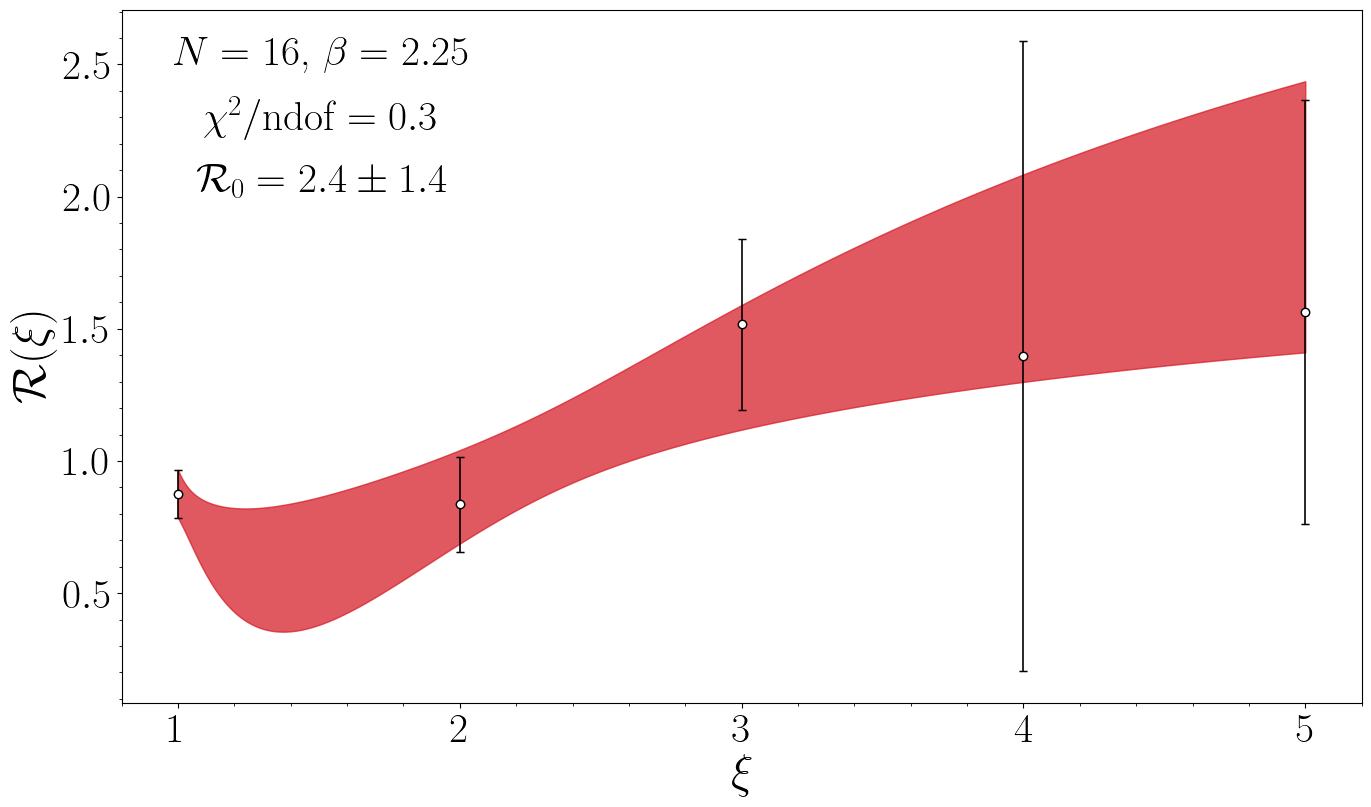

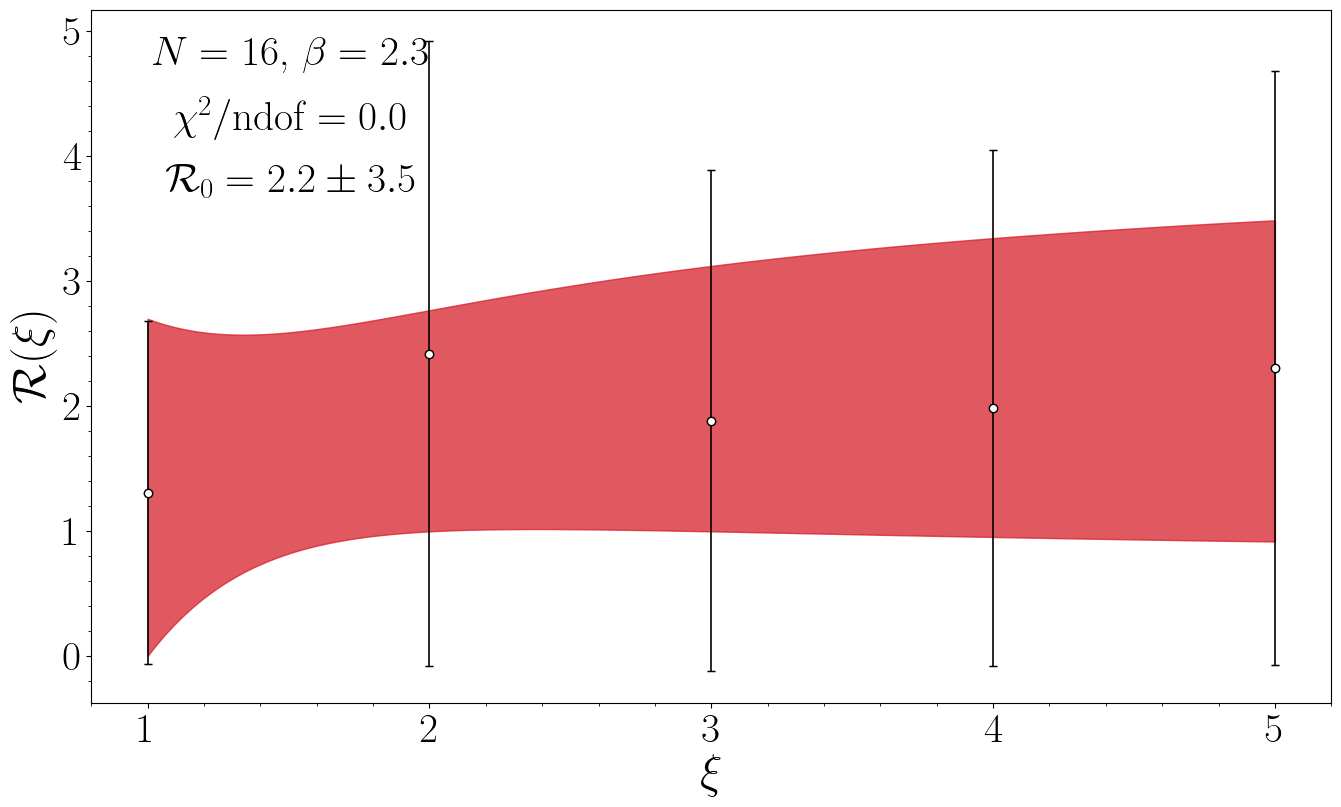

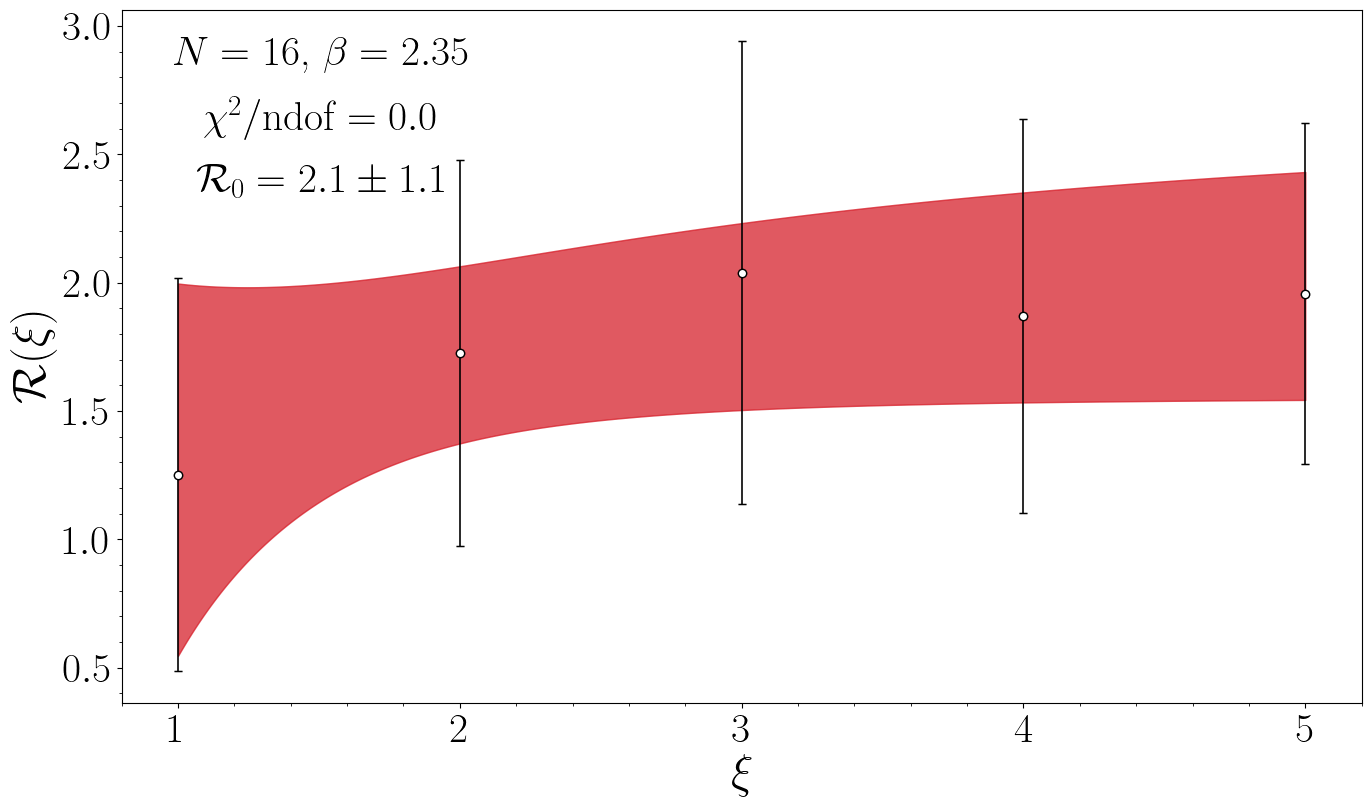

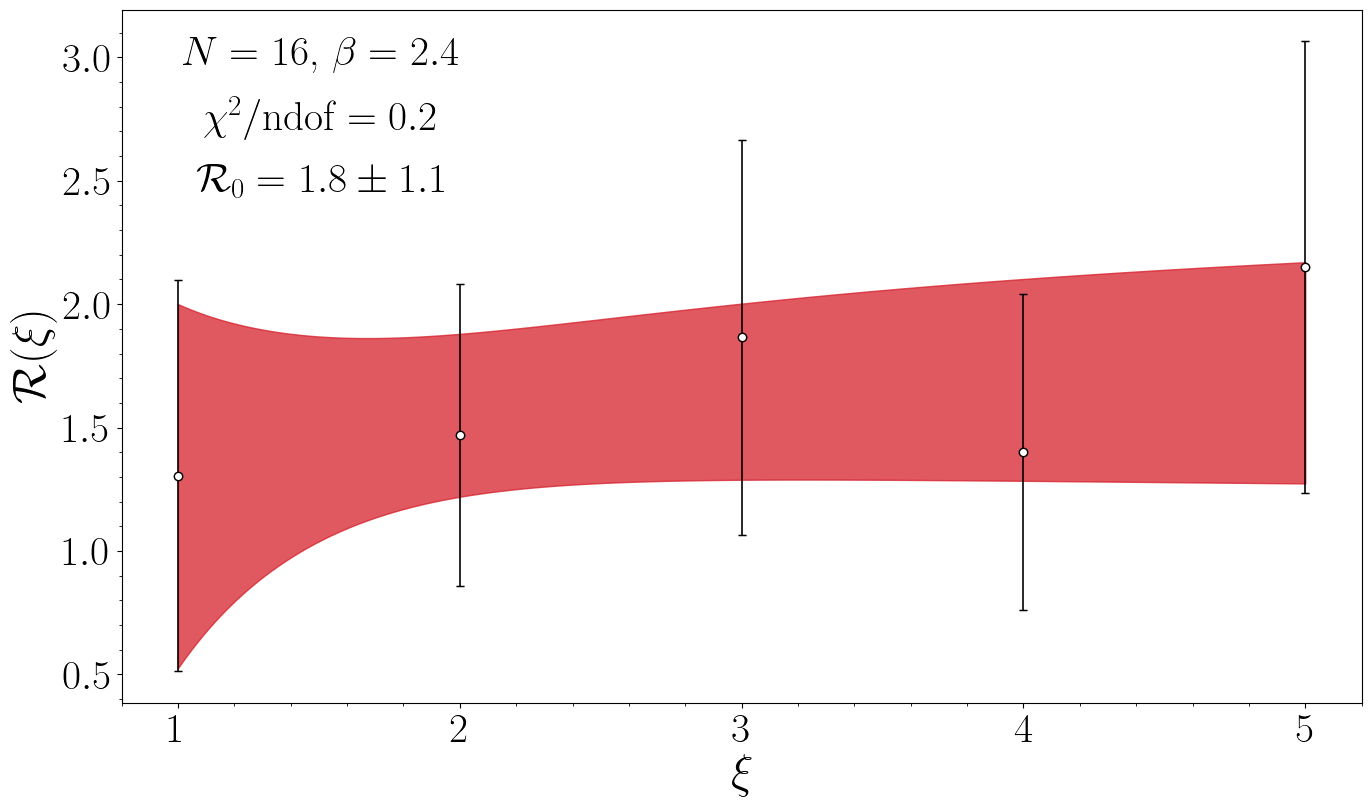

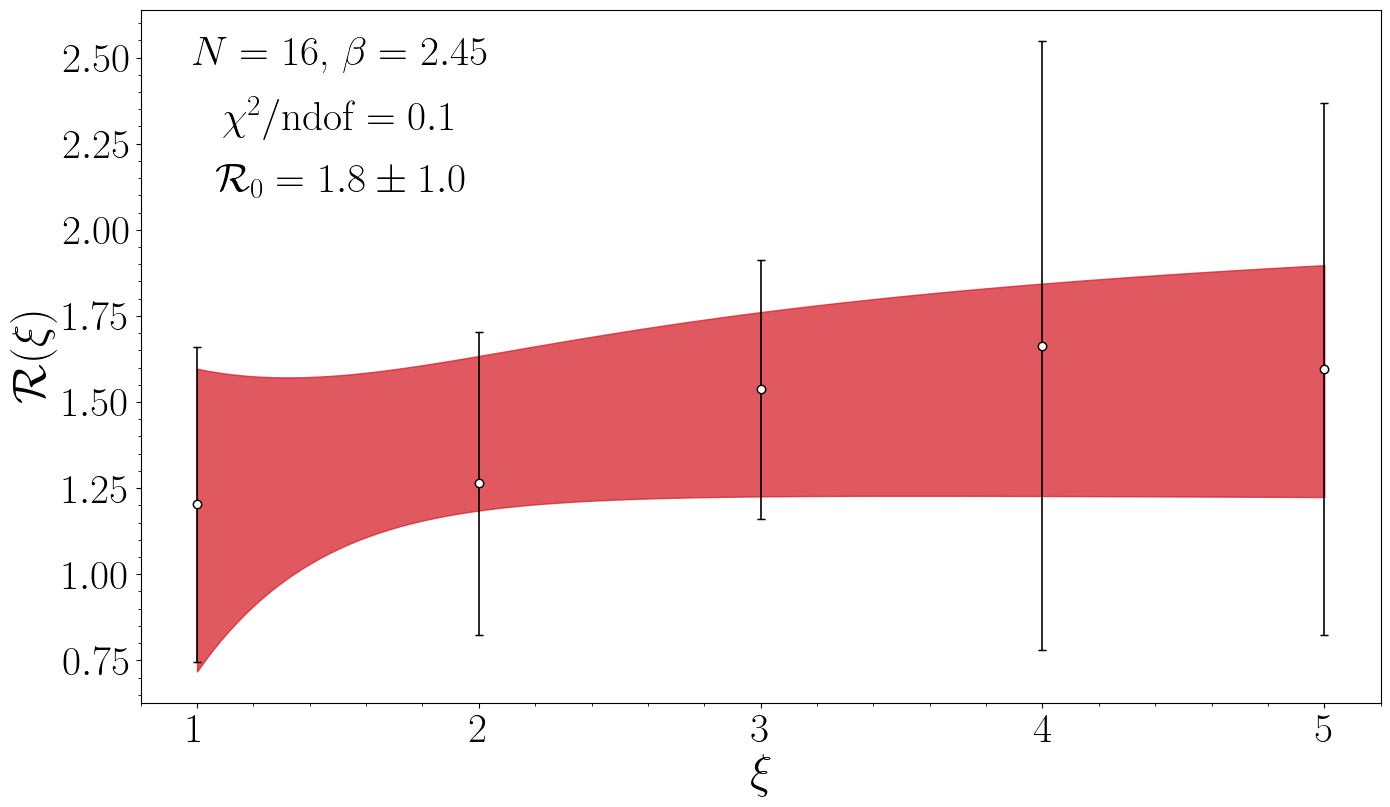

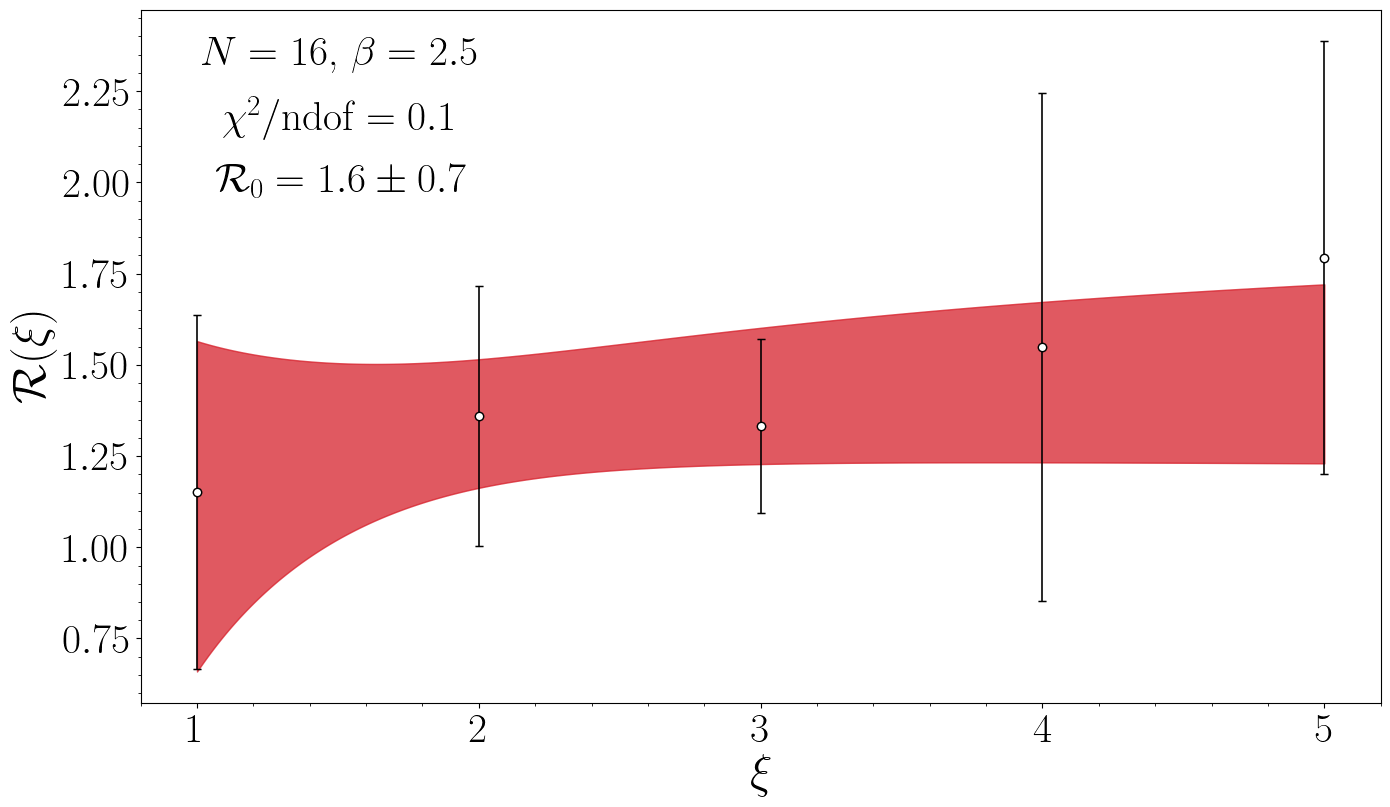

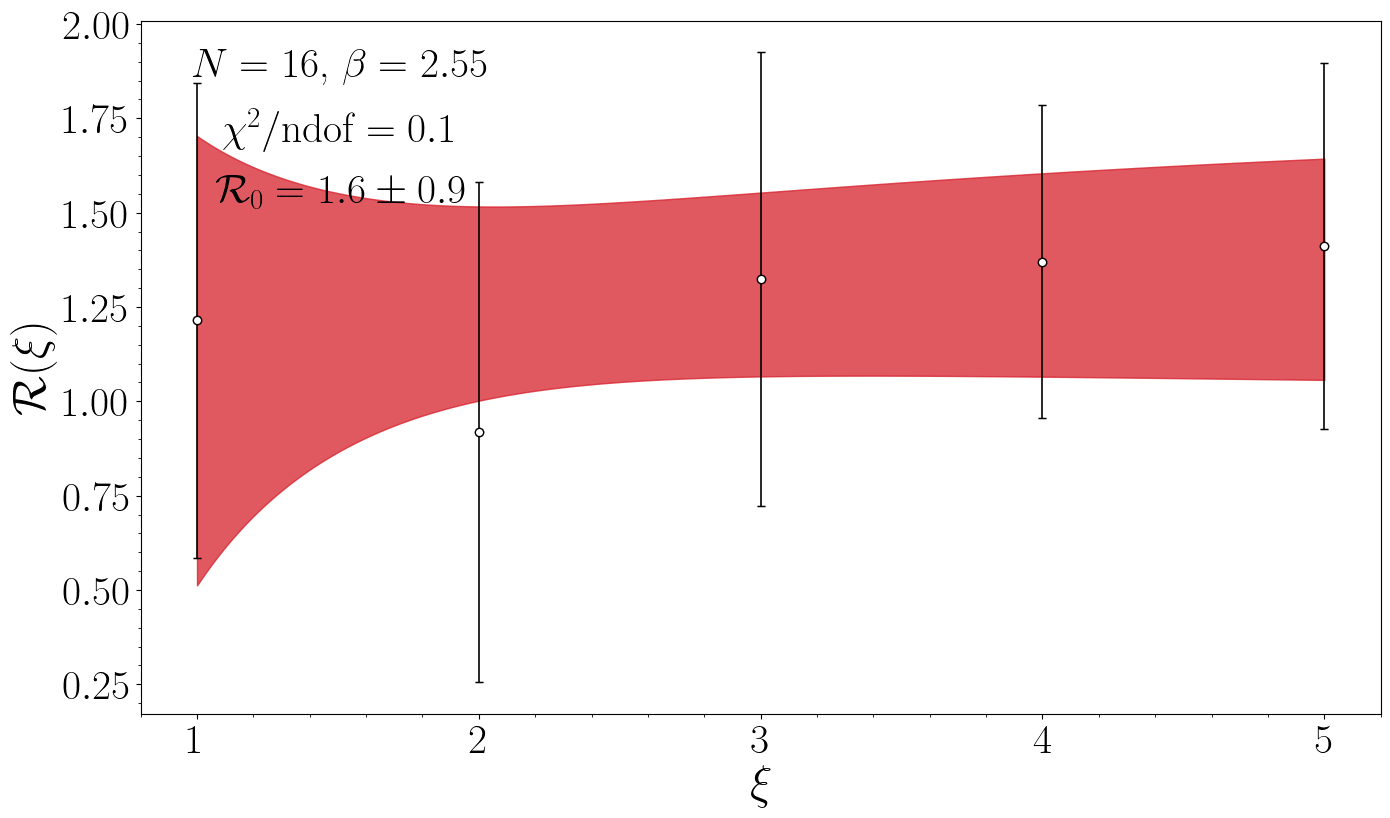

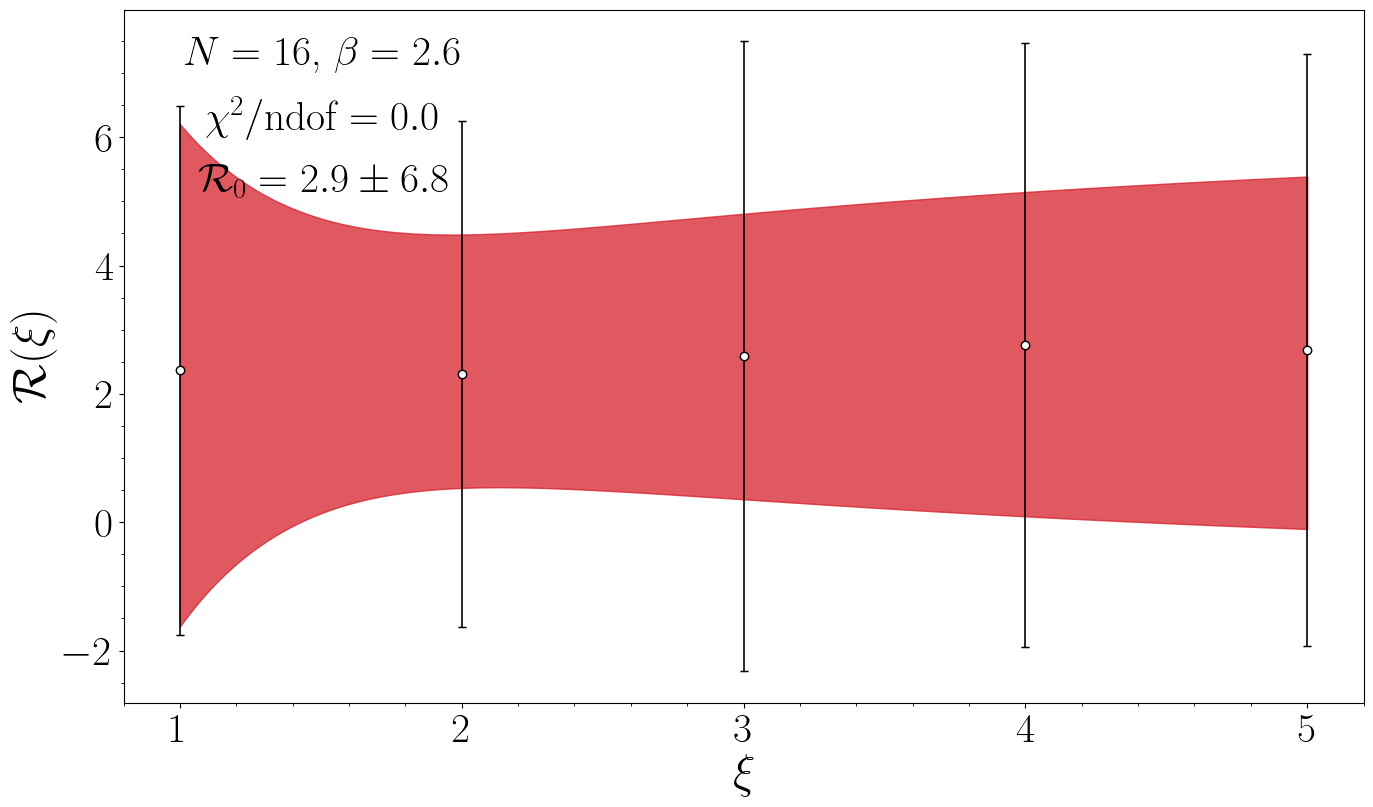

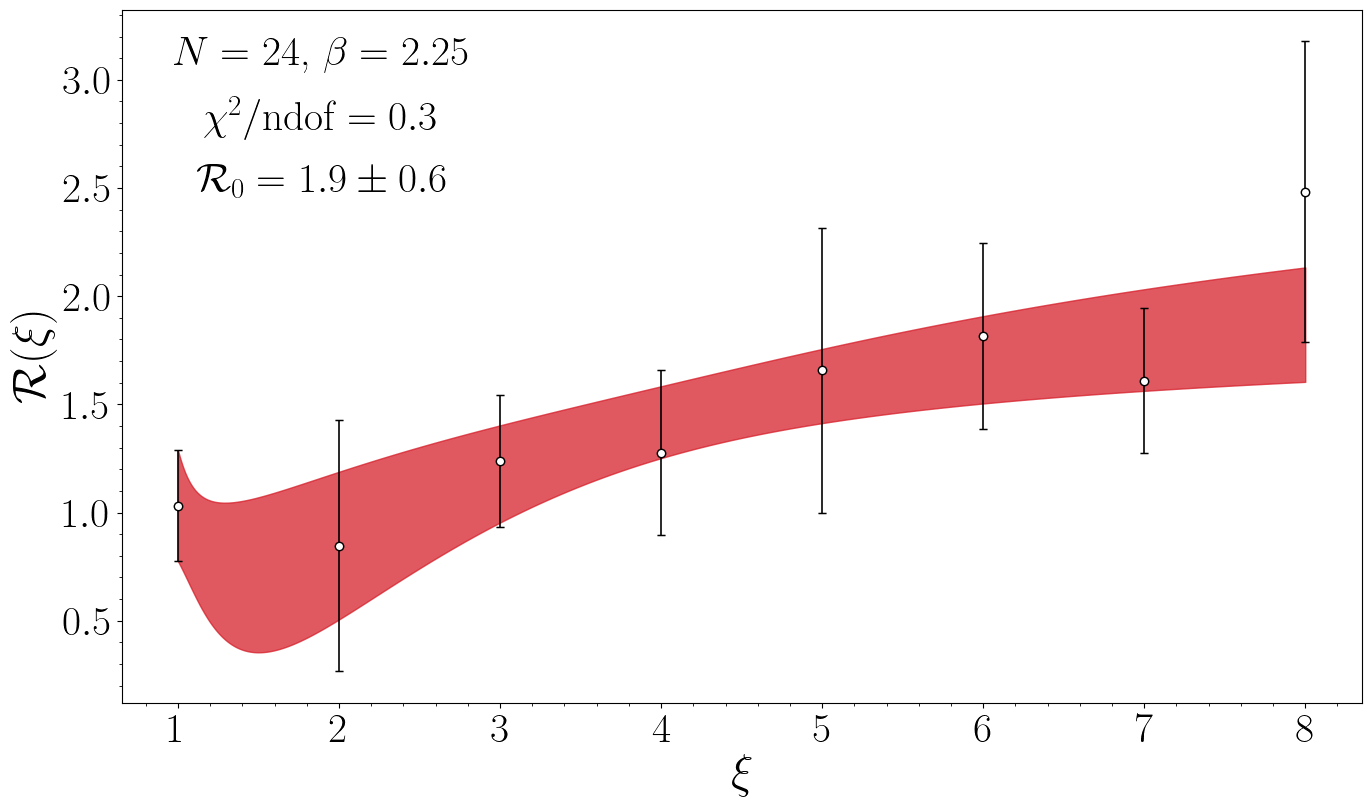

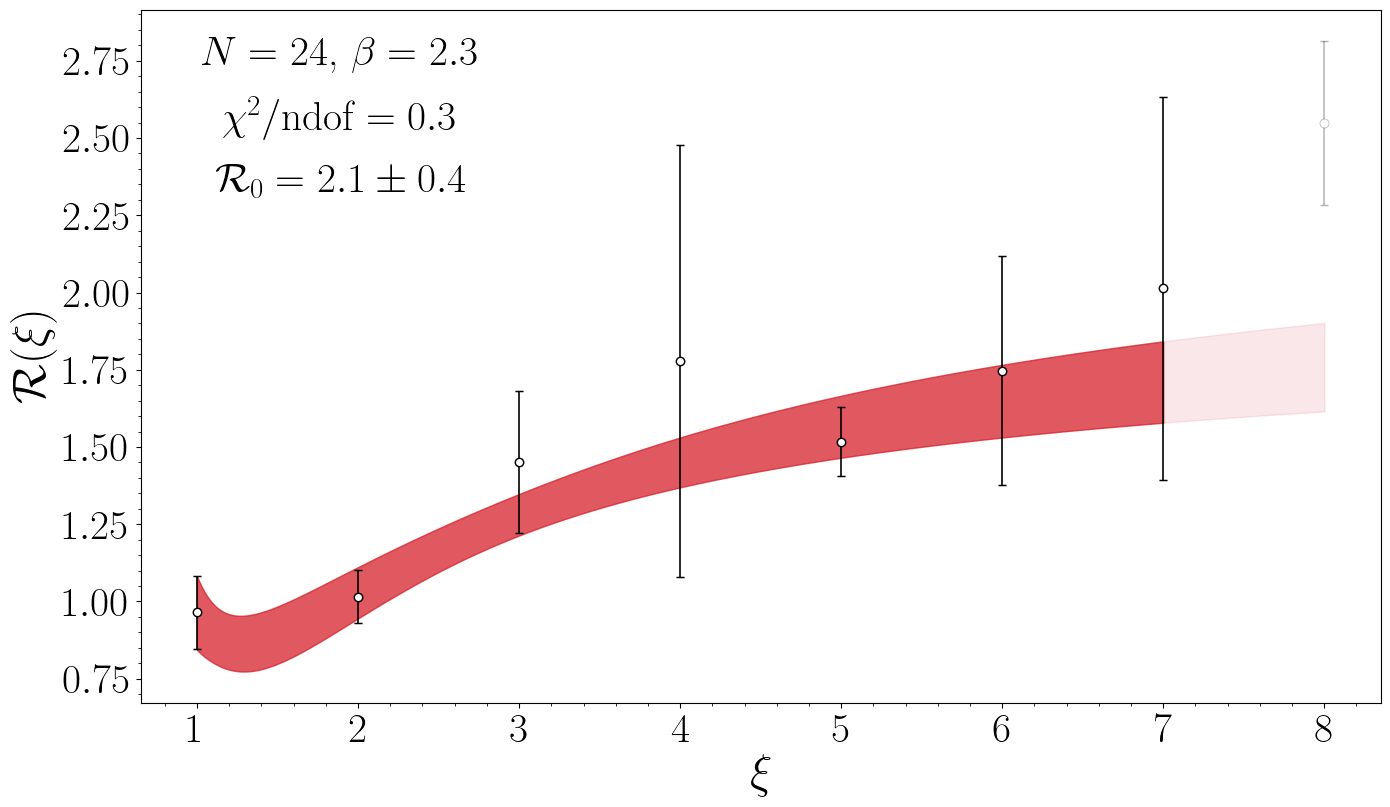

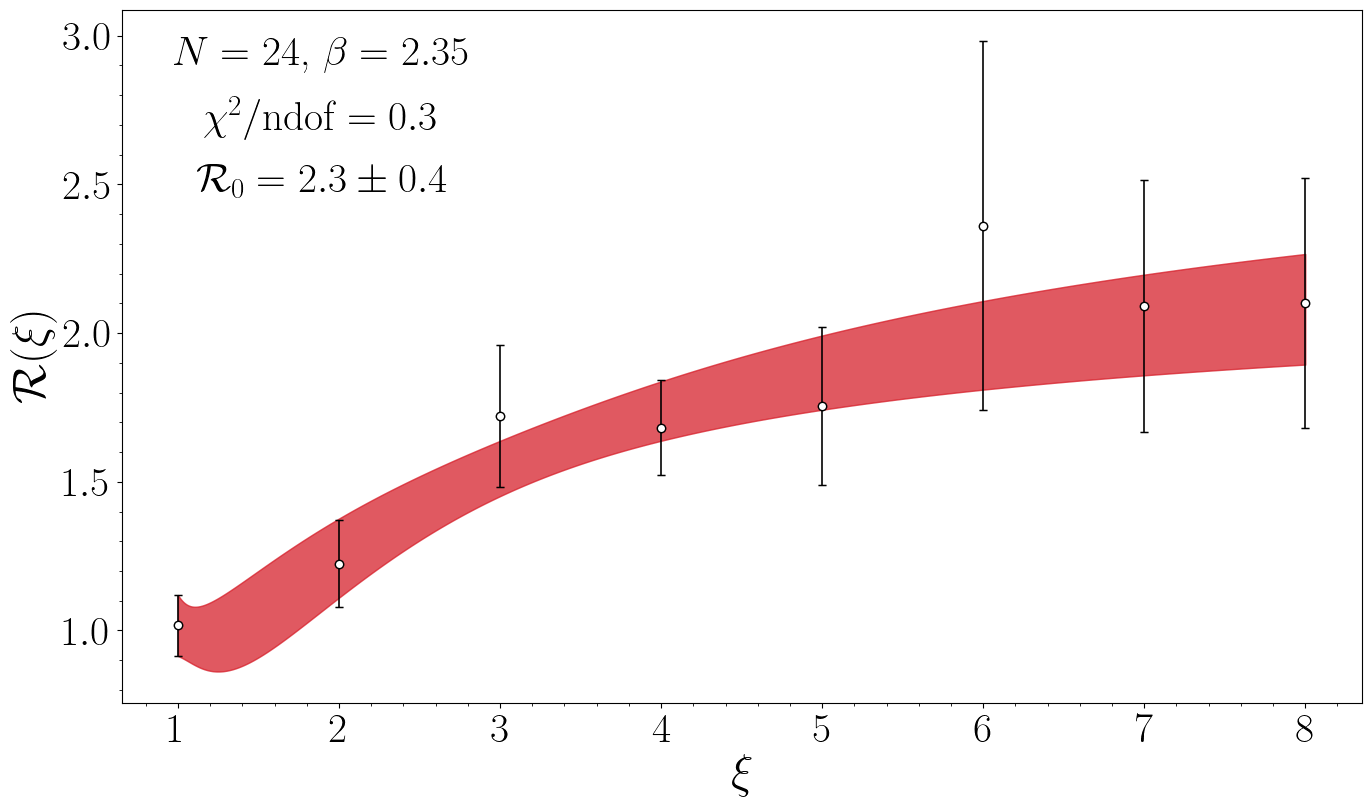

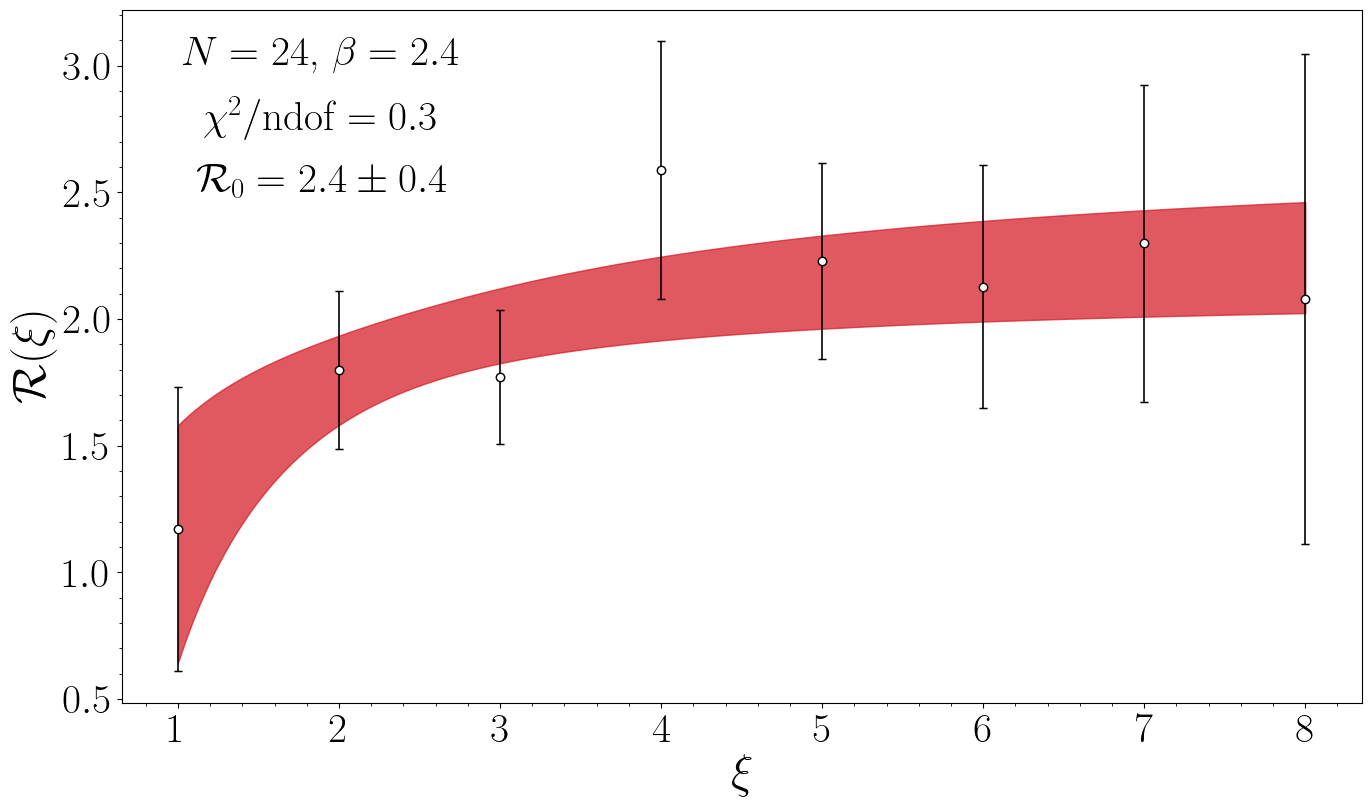

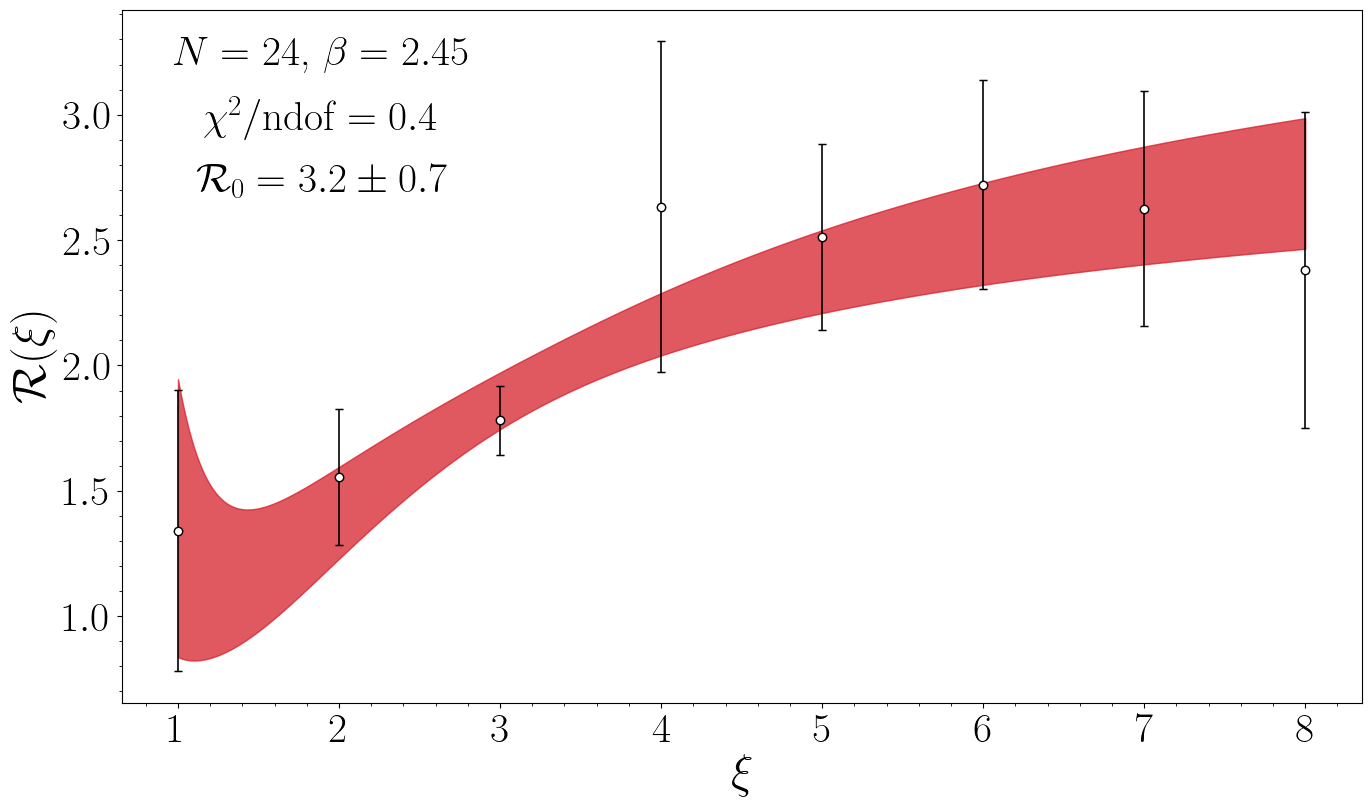

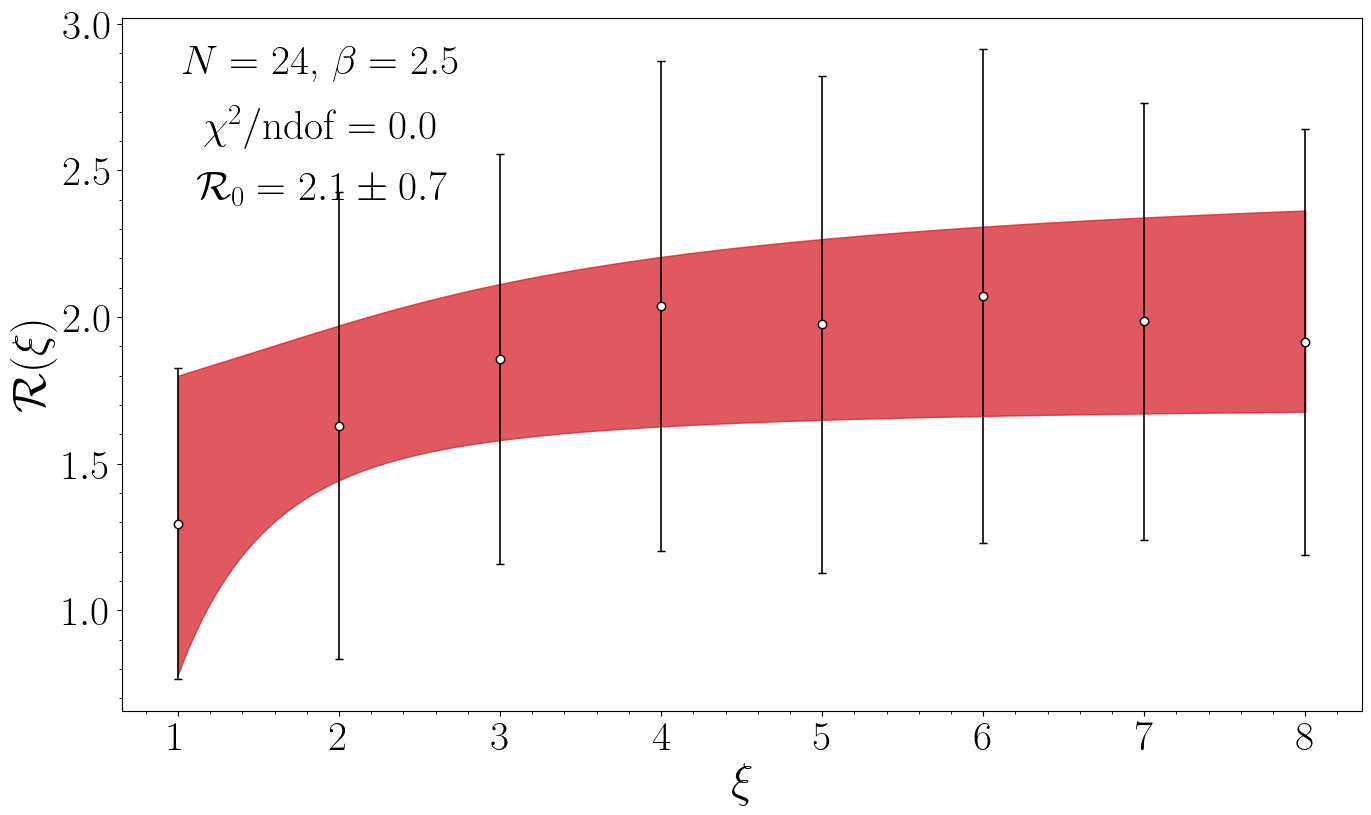

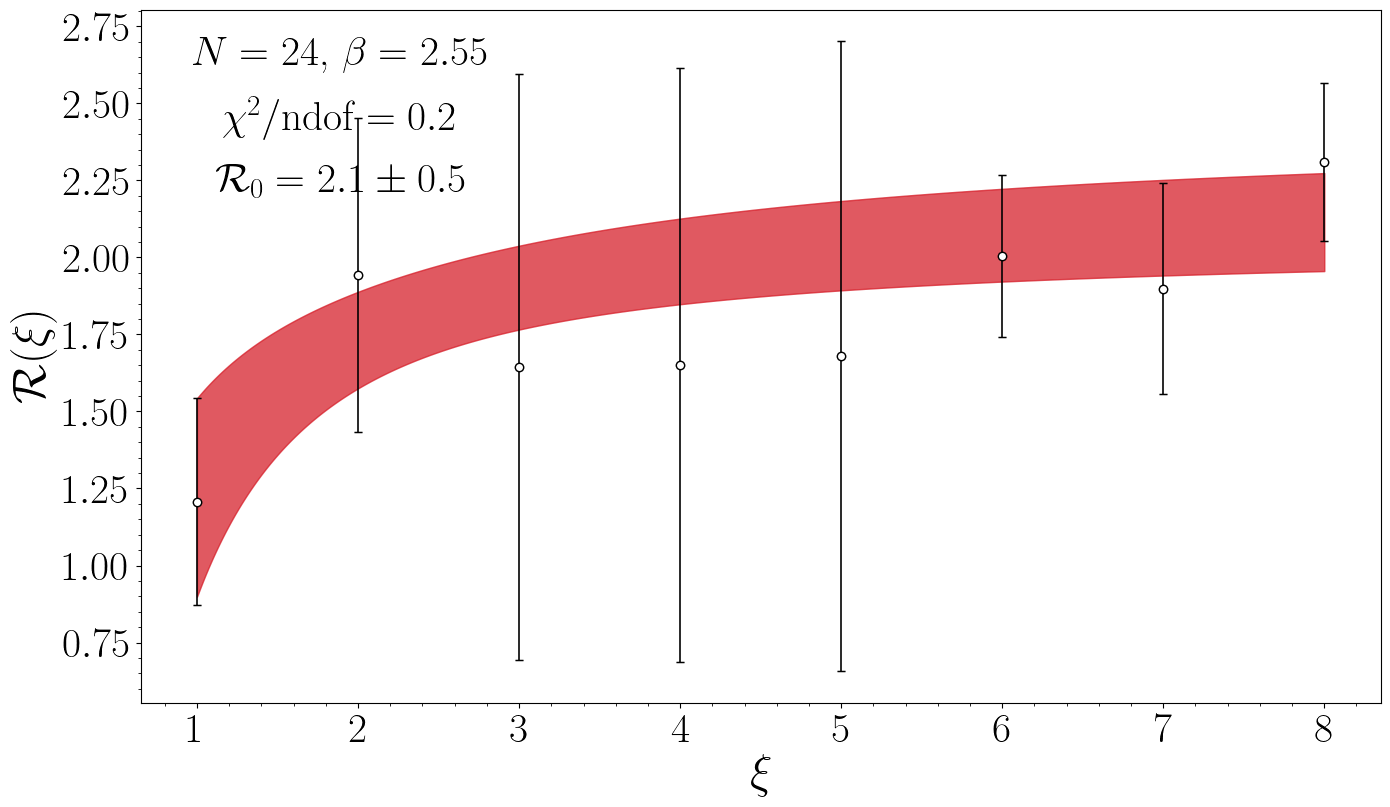

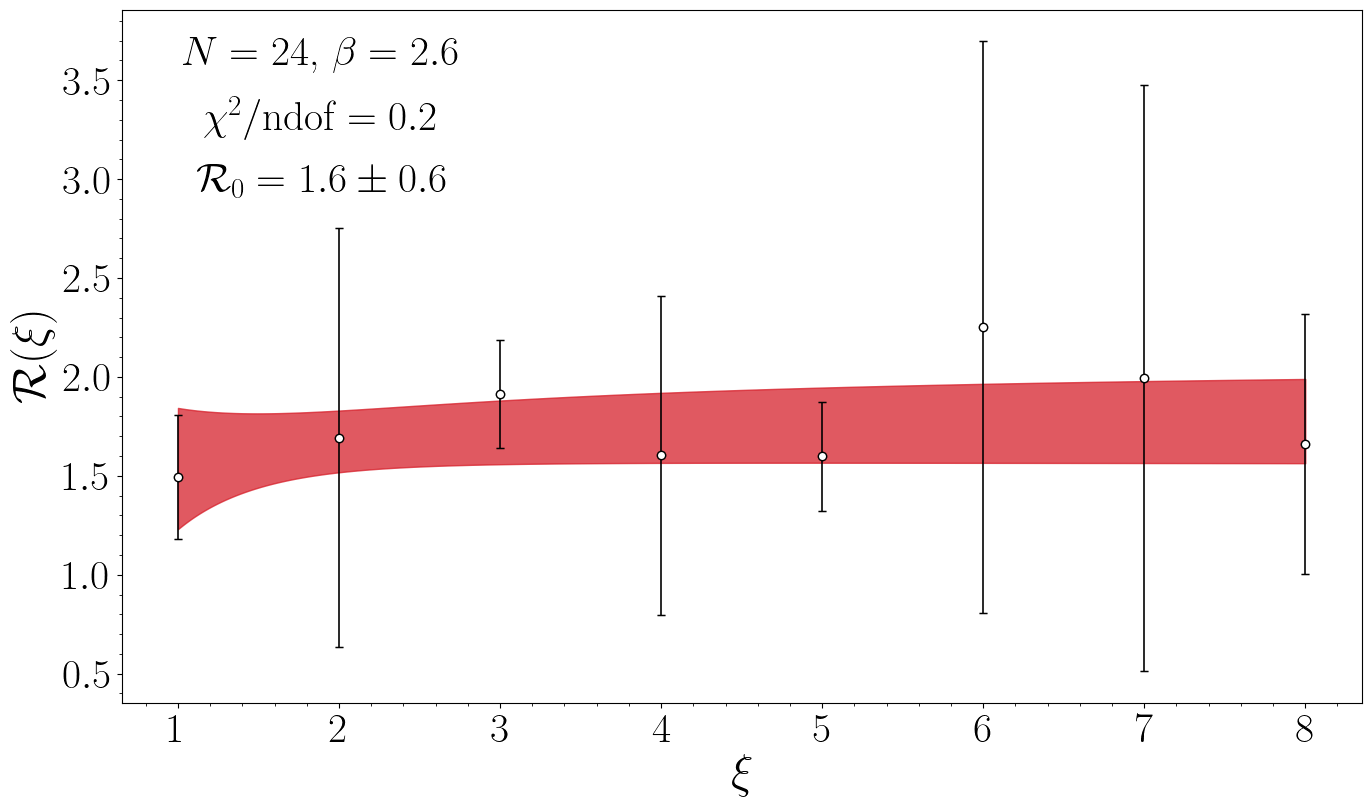

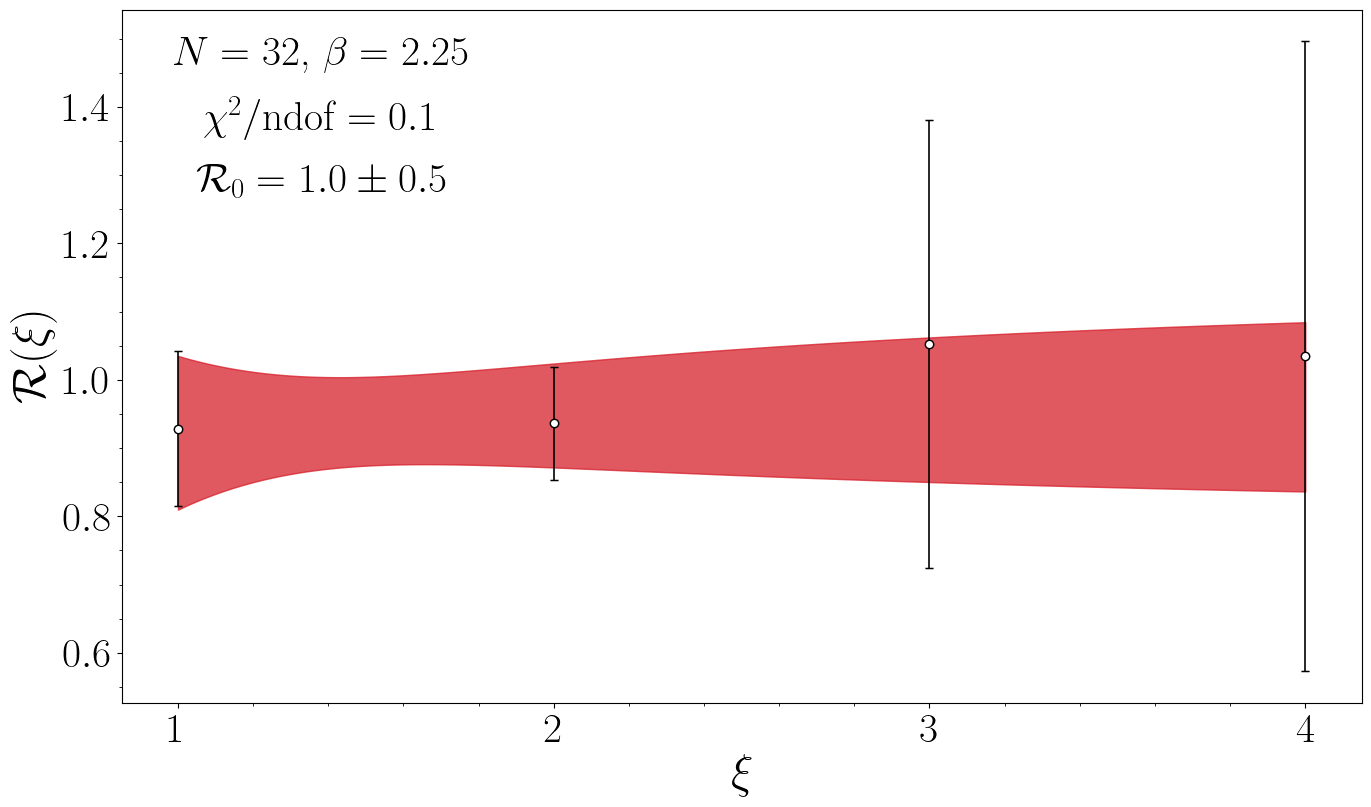

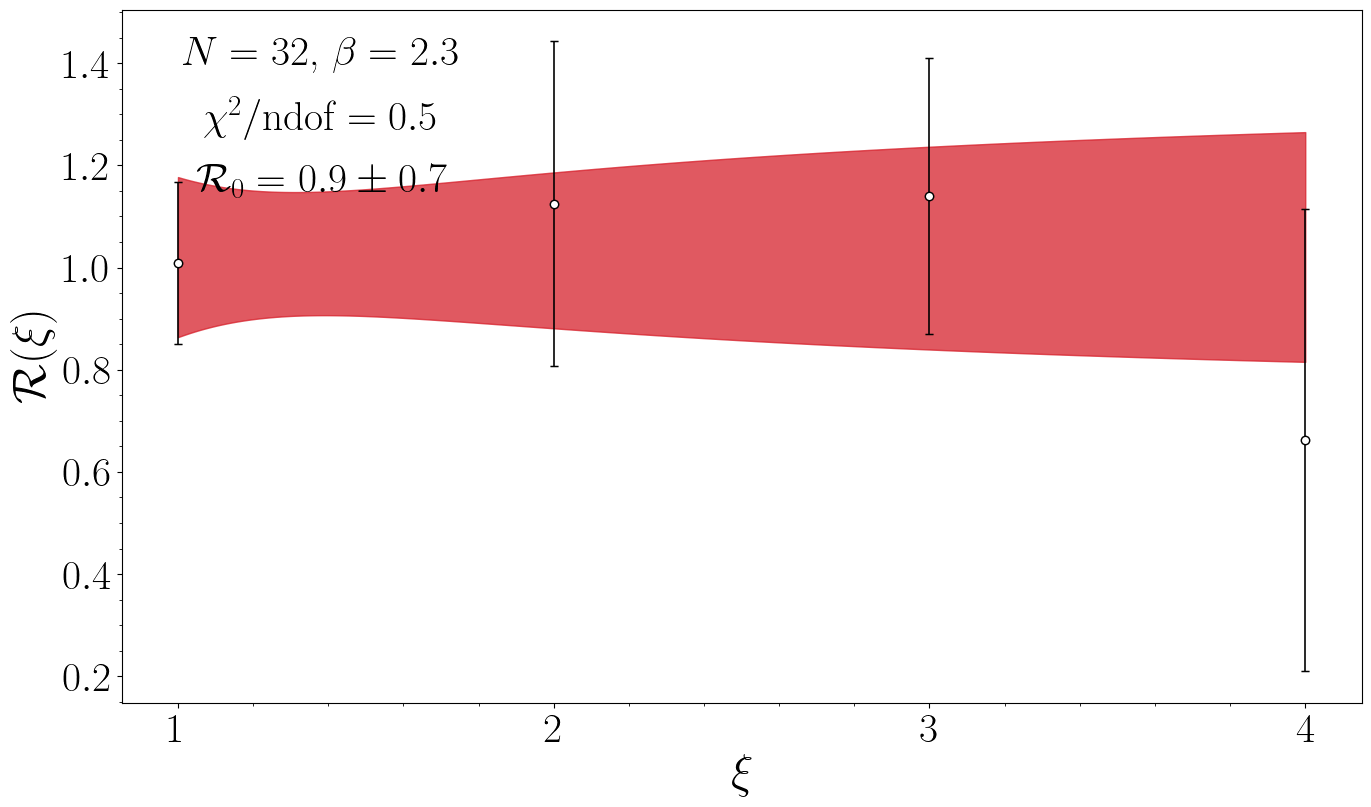

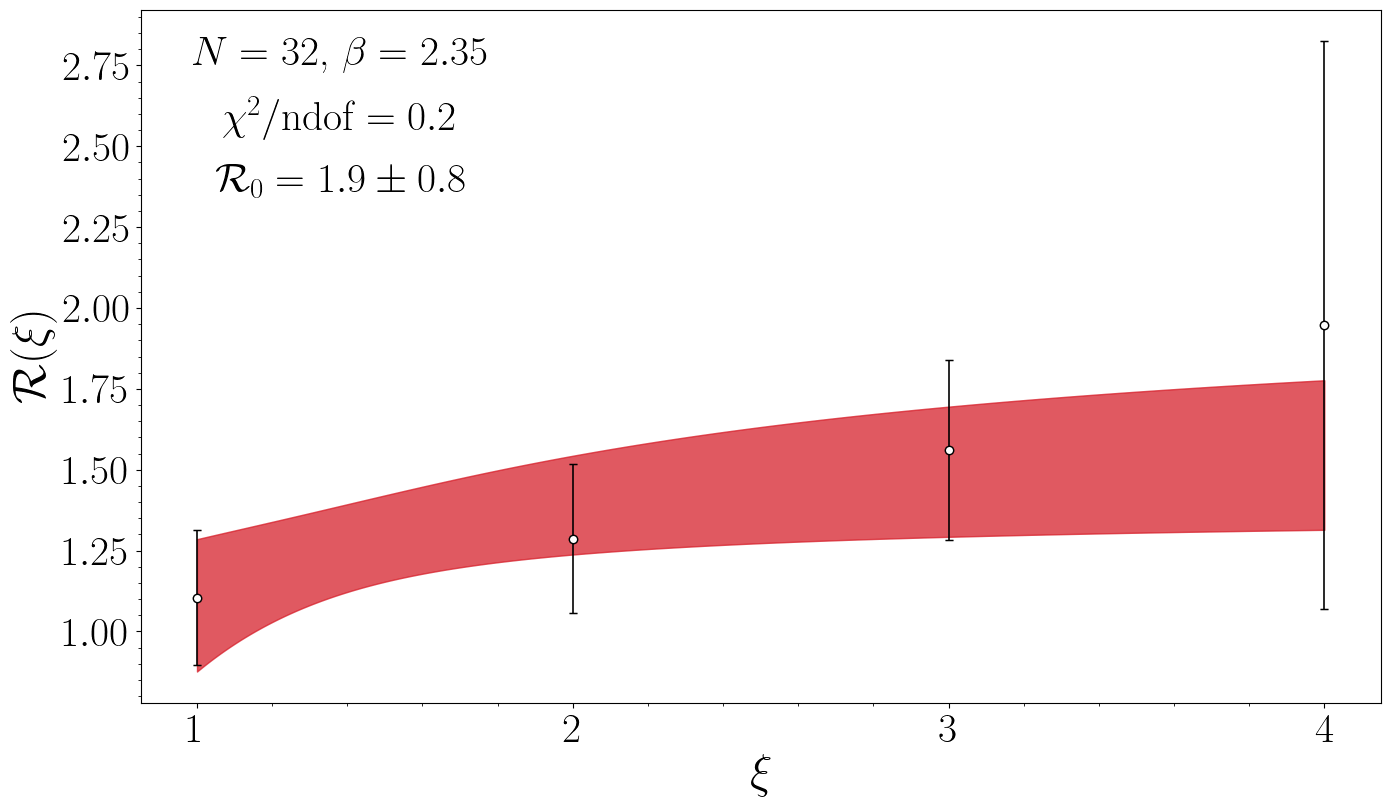

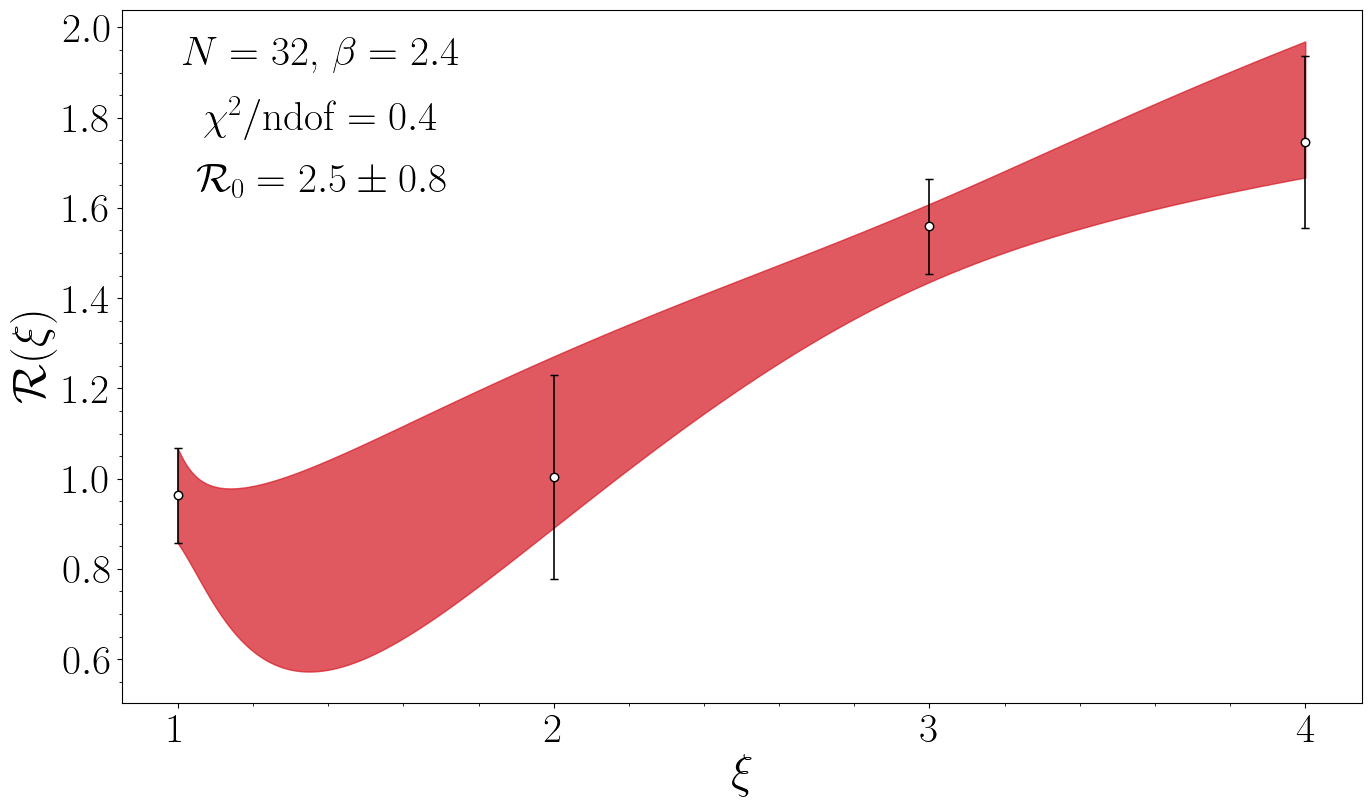

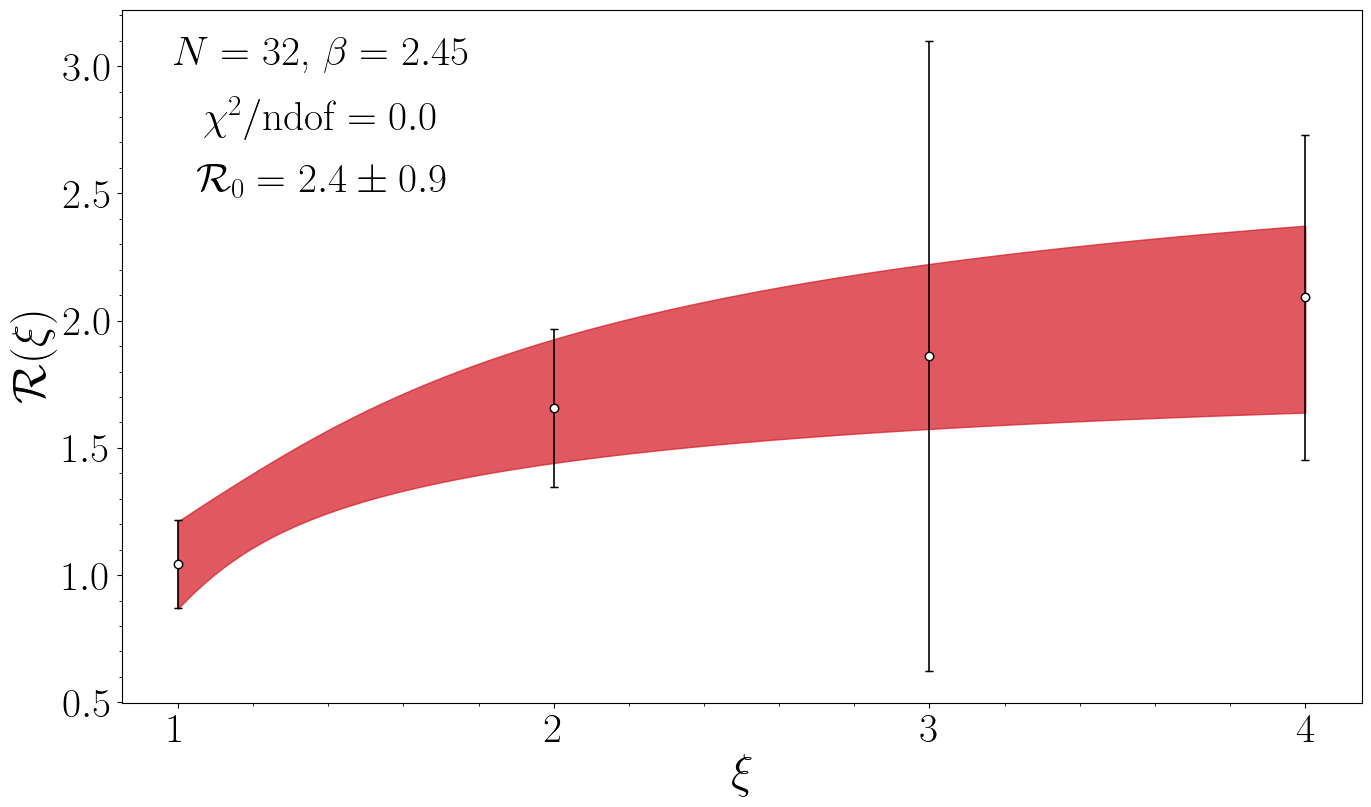

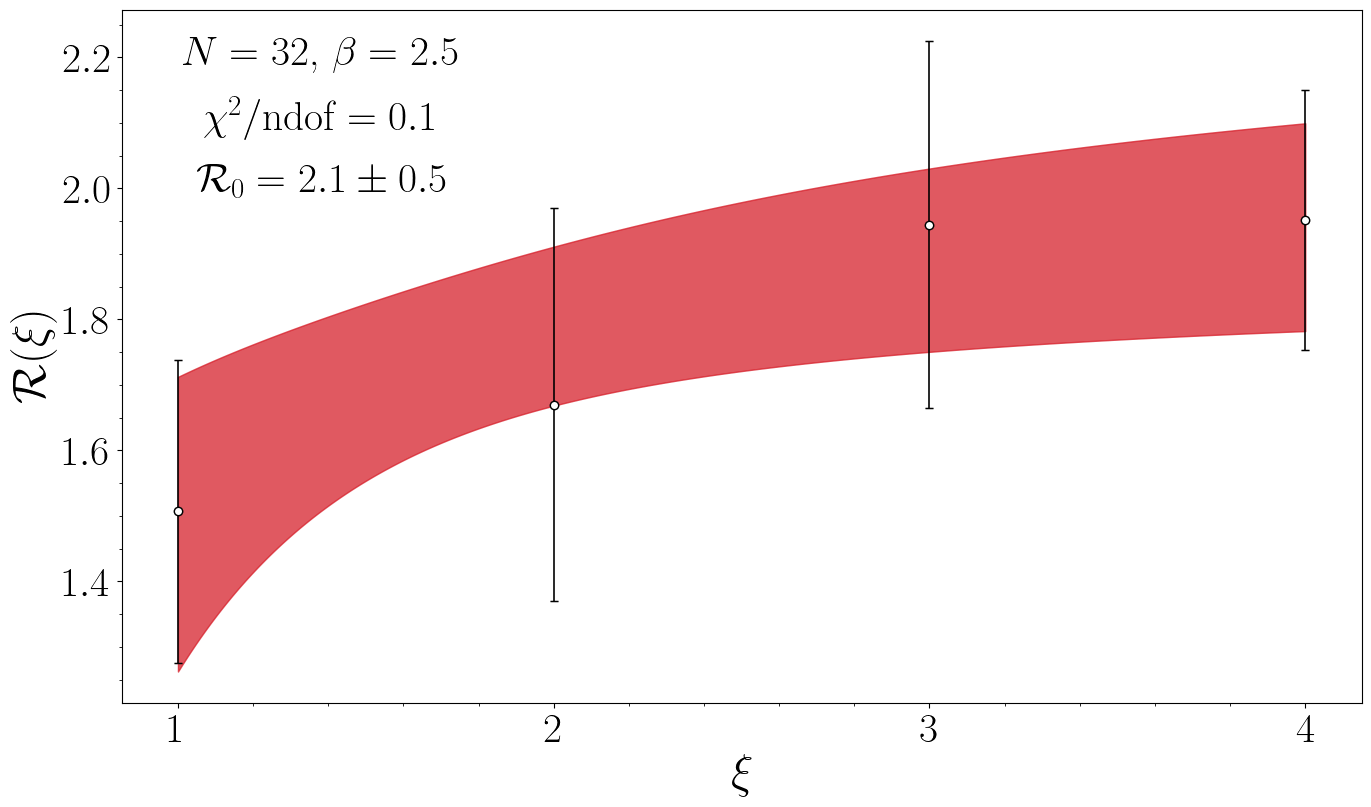

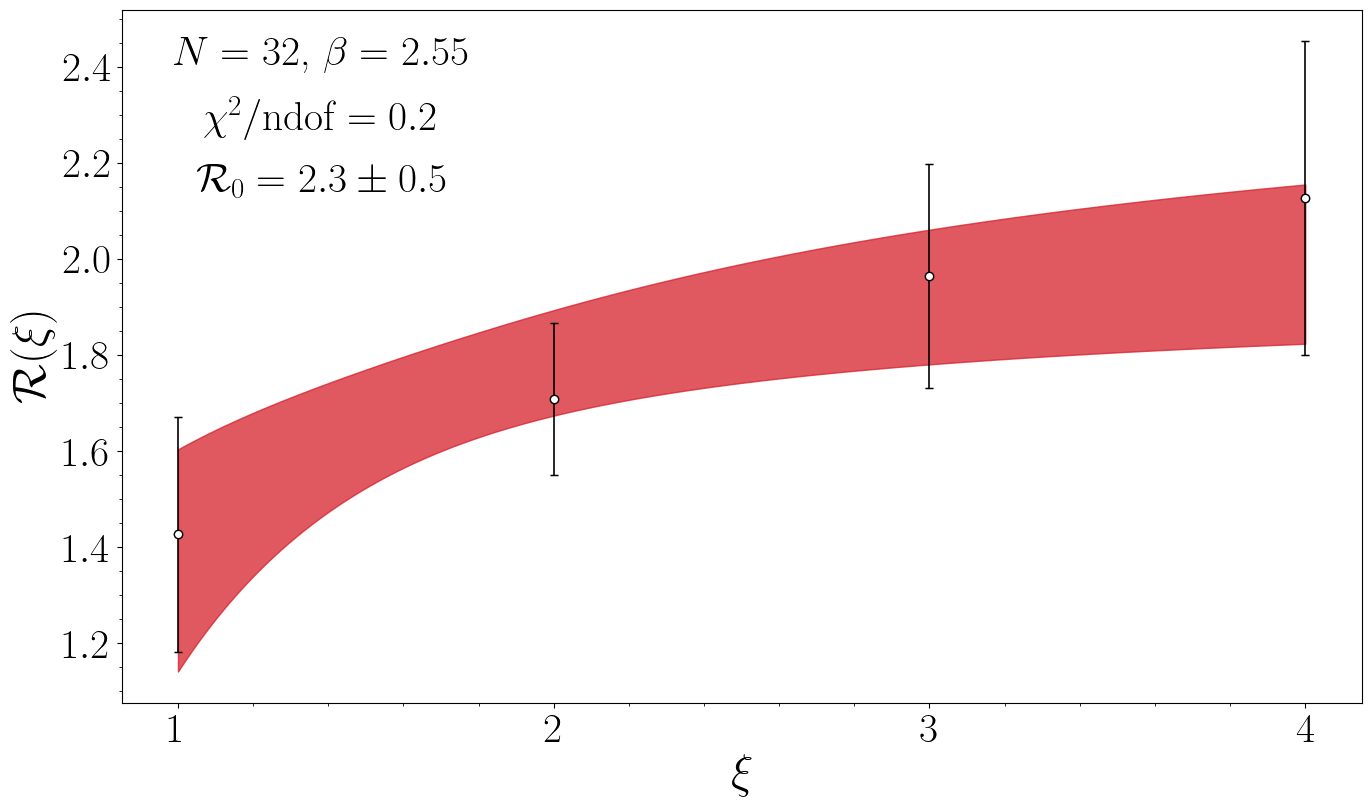

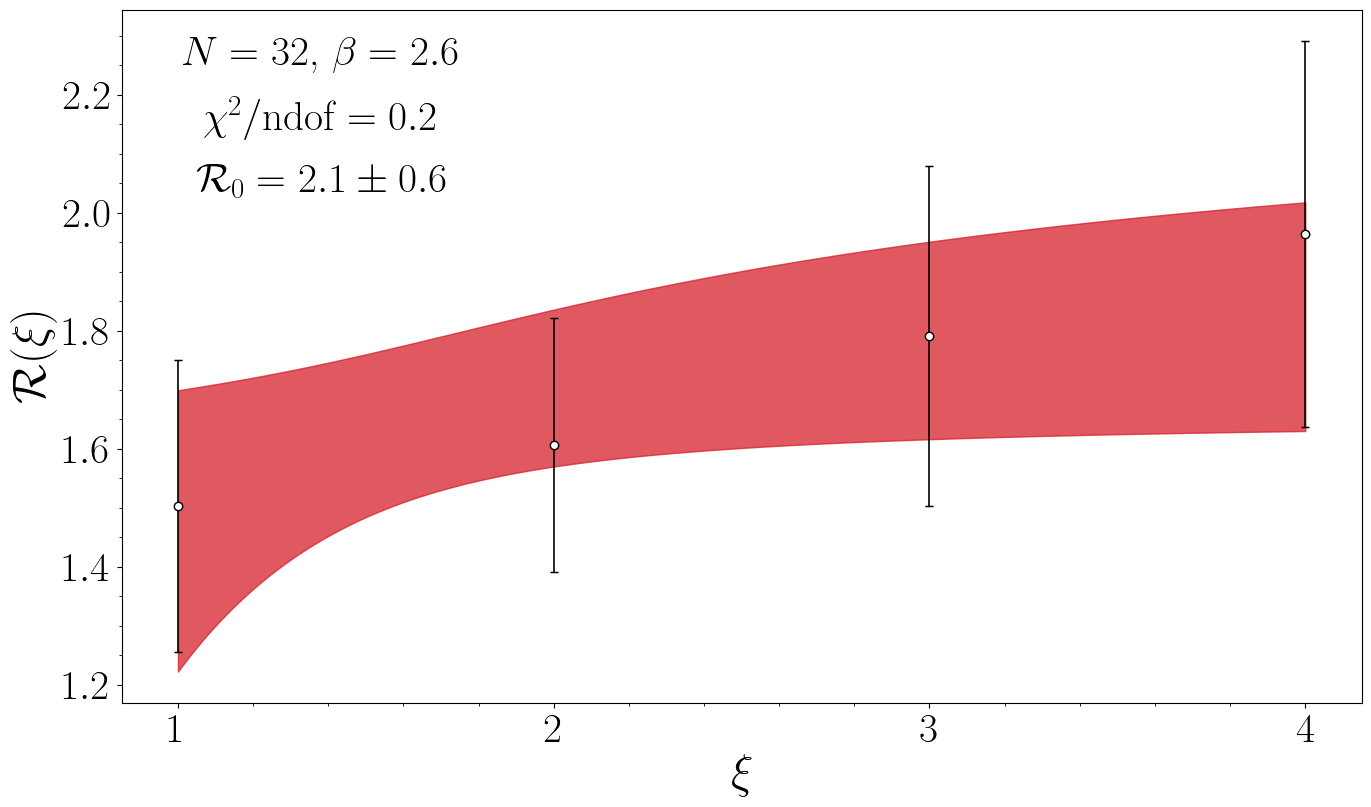

In [5]:
# Plot for ratio extrapolated to xi-->infinity

data_extrapolated     = []
data_extrapolated_err = []


for l in range(len(lattice_sizes)):

    data_extrapolated_int=[]
    data_extrapolated_err_int=[]

    xilen=len(xirun[l][0])
    betalen=len(betarun[0])

    inipars=[[2.0,0.],[2.0,0.,0.]]
    variants=['linear','quadratic']
    model='extrapolate_xi'

    datatype='ratio'

    dini=1
    dstop=0
    dmindata=3
    dfin=10

    ratio     = []
    ratio_err = []

    data_extrapolated_int    = []
    data_extrapolated_err_int= []
    for k in range(betalen):
        plt.figure(figsize=(16,9))

        data_xi   = np.linspace(1, xilen, xilen)
        data_y   = np.transpose(f_data_ratios[l])[k]
        data_err  = np.transpose(f_data_ratios_err[l])[k]
        data_cov = np.zeros((xilen,xilen))
        for i in range(xilen):
            data_cov[i,i]=data_err[i]**2
    
        m=Modelsmin( data_xi, data_y, data_cov, dini, dstop, dmindata, dfin, inipars, model, variants, datatype, mcalls, mtol, reuse, inv_first, 10, cov_freeze, improve,100,no_corrs,no_valid_check)

        mf=m.minimize()
        AIC_list=AIClist(mf[1])

        selpars=np.array(AIC_list.selval()[0])
        eselpars=np.array(AIC_list.selval()[1])
        selcpars=np.array(AIC_list.selval()[2])

        bf_data_xi    = data_xi[int(AIC_list.ordered()[0][1])-1:int(AIC_list.ordered()[0][2])]
        bf_data_y     = data_y[int(AIC_list.ordered()[0][1])-1:int(AIC_list.ordered()[0][2])] 
        bf_data_y_err = data_err[int(AIC_list.ordered()[0][1])-1:int(AIC_list.ordered()[0][2])] 

        data_xif    = np.linspace(data_xi[0], data_xi[-1], 100*len(data_xi))
        bf_data_xif = np.linspace(bf_data_xi[0], bf_data_xi[-1], 100*len(bf_data_xi))

        mafit   = eval(model)(data_xif,*selpars)
        emafit  = prop_err(data_xif,model,selpars,eselpars,selcpars)
        mafits  = eval(model)(bf_data_xif,*selpars)
        emafits = prop_err(bf_data_xif,model,selpars,eselpars,selcpars)

        data_extrapolated_int.append(np.array(AIC_list.avgval0()[0]))
        data_extrapolated_err_int.append(np.array(AIC_list.avgval0()[1]))
        #RepeatSingleFit(data_xi, data_y, data_cov, xi_ini, xi_fin, inipars, funfit , mcalls, mtol,0,1,0,0,5,100)
        #ratio.append(np.array(m.minimize().values[0]))
        #ratio_err.append(np.array(m.minimize().errors[0]))
        plt.errorbar(data_xi, data_y, data_err, alpha=0.3, fmt='ok',markerfacecolor='white')#, label='$\\beta={}$'.format(betarun[0][k]))
        plt.errorbar(data_xi, data_y, alpha=1.0,fmt='ok',markerfacecolor='white',markeredgecolor='none')
        plt.errorbar(bf_data_xi, bf_data_y, bf_data_y_err, alpha=1.0,fmt='ok',markerfacecolor='white')
        
        constant_ratio=np.zeros(len(data_xi))+4/3
        #plt.plot(data_xi, constant_ratio,alpha=1,color='black',linestyle='dashed',linewidth= 2.5,dashes=(7, 3))
        plt.fill_between(data_xif, mafit+emafit,mafit-emafit,alpha=0.1,color=jpac_red)
        plt.fill_between(bf_data_xif, mafits+emafits,mafits-emafits,alpha=0.7,color=jpac_red)

        plt.figtext(0.25, 0.83, 
        '$N={}$, $\\beta={}$'.format(lattice_sizes[l],betarun[0][k]/betanorm), 
        horizontalalignment ="center",  
        verticalalignment ="center",  
        wrap = True, fontsize = 30,  
        color ="black")
        plt.figtext(0.25, 0.76, 
        '$\\chi^2/\\text{{ndof}}={:.1f}$'.format(AIC_list.ordered()[0,4][0]), 
        horizontalalignment ="center",  
        verticalalignment ="center",  
        wrap = True, fontsize = 30,  
        color ="black")
        plt.figtext(0.25, 0.69, 
        '$\\mathcal{{R}}_0={:.1f}\\pm{:.1f}$'.format(AIC_list.avgval()[0][0],AIC_list.avgval()[1][0]), 
        horizontalalignment ="center",  
        verticalalignment ="center",  
        wrap = True, fontsize = 30,  
        color ="black")

        plt.ylabel("$\\mathcal{{R}}(\\xi)$",rotation=90,fontsize = 34)
        plt.xlabel("$\\xi$",fontsize = 34)
        
        plt.xticks(np.linspace(data_xi[0],data_xi[-1],len(data_xi)),fontsize = 30)
        plt.yticks(fontsize = 30)
        plt.savefig('../../final_plots/final_{}_{}_sigma_extrapolated_L={}_beta={}_ti{}_{}_tfin{}_tmin{}_rmin{}_{}_rfin{}_nocorrs={}_{}.pdf'.format(len(variants_Gc),model_Gc,lattice_sizes[l],betarun[0][k],dini_Gc[0],dstop_Gc[0],dfin_Gc,dmindata_Gc,dini_Vr,dstop_Vr,dfin_Vr,no_corrs,corrtype), format="pdf", bbox_inches='tight', pad_inches=0.2)
        plt.show()

    data_extrapolated.append(data_extrapolated_int)
    data_extrapolated_err.append(data_extrapolated_err_int)

/var/folders/6f/lpqhbvqs49j3w6hj241yz3880000gn/T/ipykernel_3514/945248223.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[l].legend(loc=1)
/var/folders/6f/lpqhbvqs49j3w6hj241yz3880000gn/T/ipykernel_3514/945248223.py:86: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  axs[l].errorbar(np.array(data_t), data_y, data_err, fmt="ok", alpha=0.3,color='black',markerfacecolor='white')
/var/folders/6f/lpqhbvqs49j3w6hj241yz3880000gn/T/ipykernel_3514/945248223.py:87: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  axs[l].errorbar(np.array(data_t), data_y, fmt="ok", alpha=1,color='black',markerfacecolor='white',markeredgecolor='none')
/var/folders/

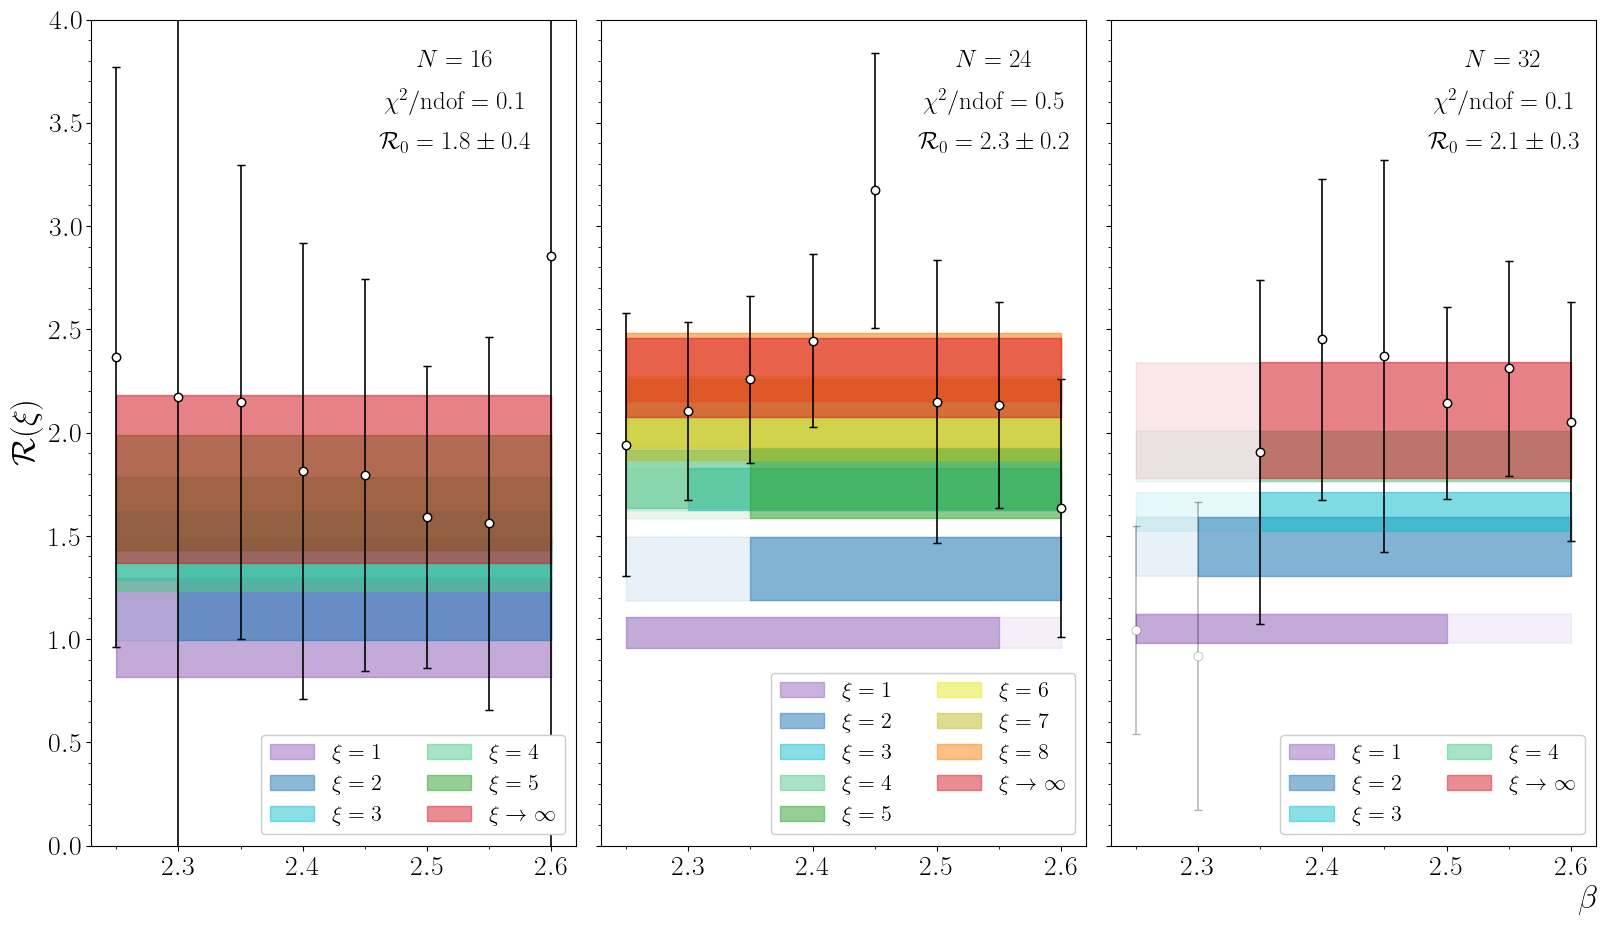

1.9137288835288222 0.5447564549220483


In [6]:
#Plot sigma for beta
inipars=[[2.0]]
variants=['constant']

dini=1
dstop=100
dmindata=6
dfin=100

model='nb_line_np'
datatype='ratio'

fig, axs = plt.subplots(1, 3,figsize=(16,9), sharex='col', sharey='row')
fig.tight_layout(w_pad=-1.5)


envelope=[]
for l in range(len(lattice_sizes)):

    xilen=len(xirun[l][0])
    for k in range(xilen):

        xi=k+1
        data_y   = f_data_ratios[l][k]
        data_err  = f_data_ratios_err[l][k]

        lt=len(data_y)

        data_t   = betax[0]
        data_cov = np.zeros((lt,lt))
        for i in range(lt):
            data_cov[i,i]=data_err[i]**2

        m=Modelsmin( data_t, data_y, data_cov, dini, dstop, dmindata, dfin, inipars, model, variants, datatype, mcalls, mtol, reuse, inv_first, 10, cov_freeze, improve,10,no_corrs,no_valid_check)

        mf=m.minimize()
        AIC_list=AIClist(mf[1])

        data_tf  = np.linspace(data_t[0],data_t[-1], 1000*lt)
        pars=np.array(AIC_list.selval0()[0])
        epars=np.array(AIC_list.selval0()[1])

        mapars=np.array(AIC_list.avgval0()[0])
        emapars=np.array(AIC_list.avgval0()[1])

        bf_data_t=data_t[int(AIC_list.ordered()[0][1])-1:int(AIC_list.ordered()[0][2])]
        bf_data_y=data_y[int(AIC_list.ordered()[0][1])-1:int(AIC_list.ordered()[0][2])]
        bf_data_err=data_err[int(AIC_list.ordered()[0][1])-1:int(AIC_list.ordered()[0][2])]

        axs[l].legend(loc=1)
        axs[l].fill_between(bf_data_t, mapars+emapars, mapars-emapars,color=jpac_color_around[k],alpha=0.5,label='$\\xi={}$'.format(xirun[l][0][k]))
        #axs[l].fill_between(bf_data_t, mapars+emapars, mapars-emapars,color=jpac_color_around[k],alpha=0.5,label='$\\chi^2/\\text{{ndof}}={:.1f}$'.format(AIC_list.ordered()[0,5].fval/AIC_list.ordered()[0,5].ndof))
        axs[l].fill_between(data_tf, mapars+emapars, mapars-emapars,color=jpac_color_around[k],alpha=0.1)


    data_y   = data_extrapolated[l]
    data_err = data_extrapolated_err[l]

    lt=len(data_y)

    data_t   = betax[0]

    data_cov = np.zeros((lt,lt))
    for i in range(lt):
        data_cov[i,i]=data_err[i]**2

    m=Modelsmin( data_t, data_y, data_cov, dini, dstop, dmindata, dfin, inipars, model, variants, datatype, mcalls, mtol, reuse, inv_first, 10, cov_freeze, improve,10,no_corrs,no_valid_check)

    mf=m.minimize()
    AIC_list=AIClist(mf[1])

    data_tf  = np.linspace(data_t[0],data_t[-1], 1000*lt)

    pars=np.array(AIC_list.selval0()[0])
    epars=np.array(AIC_list.selval0()[1])

    mapars=np.array(AIC_list.avgval0()[0])
    emapars=np.array(AIC_list.avgval0()[1])

    bf_data_t=data_t[int(AIC_list.ordered()[0][1])-1:int(AIC_list.ordered()[0][2])]
    bf_data_y=data_y[int(AIC_list.ordered()[0][1])-1:int(AIC_list.ordered()[0][2])]
    bf_data_err=data_err[int(AIC_list.ordered()[0][1])-1:int(AIC_list.ordered()[0][2])]

    constant_ratio=np.zeros(len(data_t))+4/3
    #axs[l].plot(np.array(data_t), constant_ratio,alpha=1,color='black',linestyle='dashed',linewidth= 2,dashes=(5, 2))
    axs[l].errorbar(np.array(data_t), data_y, data_err, fmt="ok", alpha=0.3,color='black',markerfacecolor='white')
    axs[l].errorbar(np.array(data_t), data_y, fmt="ok", alpha=1,color='black',markerfacecolor='white',markeredgecolor='none')
    axs[l].errorbar(np.array(bf_data_t), bf_data_y, bf_data_err, fmt="ok",color='black',markerfacecolor='white')

    axs[l].fill_between(bf_data_t, mapars+emapars, mapars-emapars,color=jpac_red,alpha=0.5,label='$\\xi\\to \\infty$')
    axs[l].fill_between(data_tf, mapars+emapars, mapars-emapars,color=jpac_red,alpha=0.1)

    if (l==0):
        xpos=0.75
    else:
        xpos=0.81

    axs[l].axes.text(xpos, 0.95, 
        '$N={}$'.format(lattice_sizes[l]), 
        horizontalalignment ="center",  
        verticalalignment ="center",  
        wrap = True, fontsize = 18,  
        color ="black",transform=axs[l].transAxes)
    axs[l].axes.text(xpos, 0.9, 
        '$\\chi^2/\\text{{ndof}}={:.1f}$'.format(AIC_list.ordered()[0,4][0]), 
        horizontalalignment ="center",  
        verticalalignment ="center",  
        wrap = True, fontsize = 18,  
        color ="black",transform=axs[l].transAxes)
    axs[l].axes.text(xpos, 0.85, 
        '$\\mathcal{{R}}_0={:.1f}\\pm{:.1f}$'.format(mapars,emapars), 
        horizontalalignment ="center",  
        verticalalignment ="center",  
        wrap = True, fontsize = 18,  
        color ="black",transform=axs[l].transAxes)

    envelope.append(mapars-emapars)
    envelope.append(mapars+emapars)

    axs[2].set_xlabel("$\\beta$",loc='right')
    axs[0].set_ylabel("$\\mathcal{{R}}(\\xi)$",loc='center',rotation=90)
    x_minor_list=np.arange(0,100)/20
    axs[l].xaxis.set_minor_locator(ticker.FixedLocator((x_minor_list)))
    axs[l].set_xticks(np.linspace(data_t[0]-0.05,data_t[-1],5))
    axs[l].set_xlim(data_t[0]-0.02,data_t[-1]+0.02)
    axs[l].set_yticks(np.linspace(0,4,9))
    axs[l].set_ylim(0,4)
    axs[l].legend(fontsize=16,frameon=True,loc='lower right',ncols=2,fancybox=True,shadow=False,framealpha=1)

for axs in fig.get_axes():
    axs.label_outer()

plt.savefig('../../final_plots/final_{}_{}_sigma_ratio_ti{}_{}_tfin{}_tmin{}_rmin{}_{}_rfin{}_nocorrs={}_{}.pdf'.format(len(variants_Gc),model_Gc,dini_Gc[0],dstop_Gc[0],dfin_Gc,dmindata_Gc,dini_Vr,dstop_Vr,dfin_Vr,no_corrs,corrtype), format="pdf", bbox_inches='tight', pad_inches=0.2)
plt.show()

Rmax=max(envelope)
Rmin=min(envelope)
print((Rmax+Rmin)/2,(Rmax-Rmin)/2)

/var/folders/6f/lpqhbvqs49j3w6hj241yz3880000gn/T/ipykernel_3514/4187651927.py:53: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(np.array(data_t)[i]+shift, data_y[i], data_err[i], fmt="ok", alpha=0.3,color=jpac_color_around[k_col])
/var/folders/6f/lpqhbvqs49j3w6hj241yz3880000gn/T/ipykernel_3514/4187651927.py:62: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(np.array(bf_data_t)[i]+shift, bf_data_y[i], bf_data_err[i], fmt="ok",color=jpac_color_around[k_col],label='L={}'.format(lattice_sizes[k_col]))
/var/folders/6f/lpqhbvqs49j3w6hj241yz3880000gn/T/ipykernel_3514/4187651927.py:64: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  plt.e

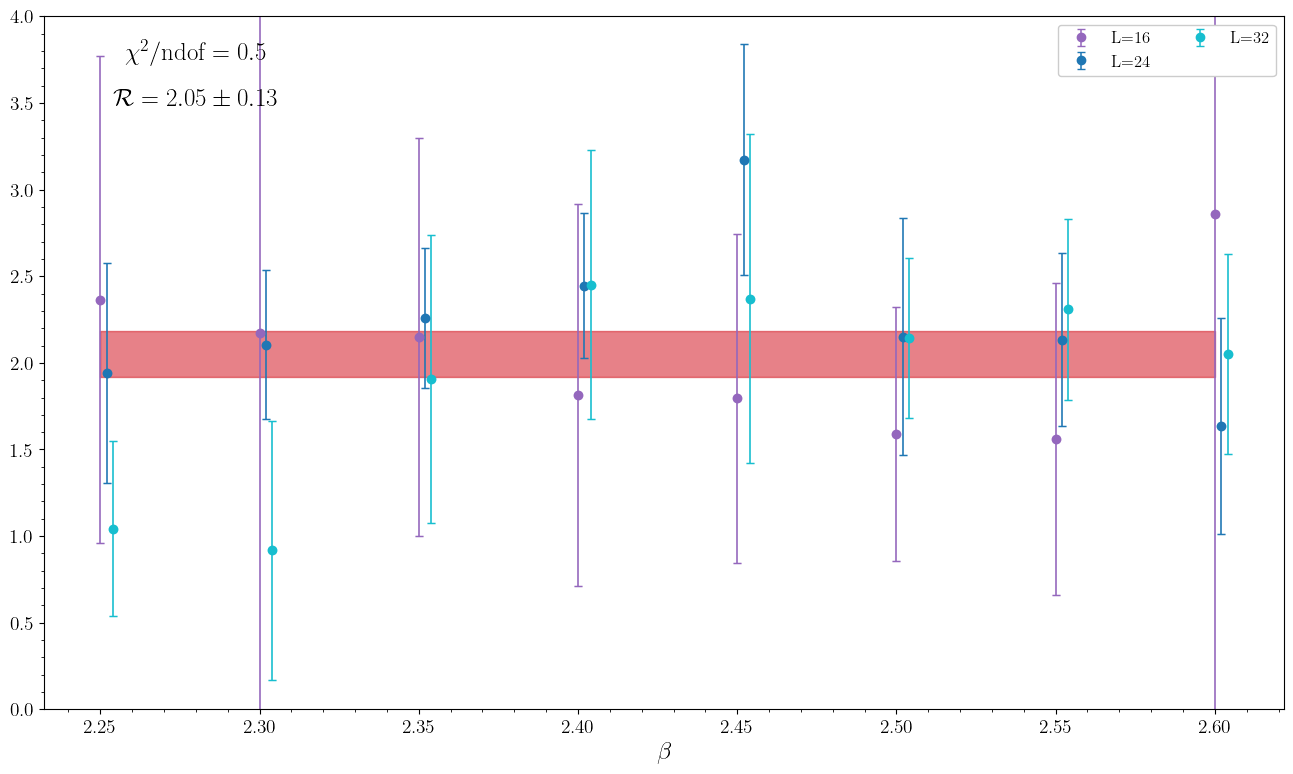

In [7]:
#Plot sigma for beta
inipars=[[2.0]]
variants=['constant']

dini=1
dstop=0
dmindata=24
dfin=24

model=line_np
datatype='ratio'

model='nb_line_np'
datatype='ratio'

fig= plt.figure(figsize=(16,9))

data_t_int  = []
data_y_int  = []
data_err_int= []
for l in range(len(lattice_sizes)):
    data_t_int+=list(betax[0])
    data_y_int+=data_extrapolated[l]
    data_err_int+=data_extrapolated_err[l]

order_index=np.argsort(data_t_int,kind='Stable')
data_t   = np.array(data_t_int)[order_index]
data_y   = np.array(data_y_int)[order_index]
data_err = np.array(data_err_int)[order_index]


lt=len(data_y)

data_cov = np.zeros((lt,lt))
for i in range(lt):
    data_cov[i,i]=data_err[i]**2

m=Modelsmin( data_t, data_y, data_cov, dini, dstop, dmindata, dfin, inipars, model, variants, datatype, mcalls, mtol, reuse, inv_first, 10, cov_freeze, improve,10,no_corrs,no_valid_check)
mf=m.minimize()
AIC_list=AIClist(mf[1])
data_tf  = np.linspace(data_t[0],data_t[-1], 1000*lt)
pars=np.array(AIC_list.selval0()[0])
epars=np.array(AIC_list.selval0()[1])
mapars=np.array(AIC_list.avgval0()[0])
emapars=np.array(AIC_list.avgval0()[1])
bf_data_t=data_t[int(AIC_list.ordered()[0][1])-1:int(AIC_list.ordered()[0][2])]
bf_data_y=data_y[int(AIC_list.ordered()[0][1])-1:int(AIC_list.ordered()[0][2])]
bf_data_err=data_err[int(AIC_list.ordered()[0][1])-1:int(AIC_list.ordered()[0][2])]

for i in range(len(data_t)):
    k_col=divmod(order_index[i],len(betax[0]))[0]
    shift=0.002*k_col
    plt.errorbar(np.array(data_t)[i]+shift, data_y[i], data_err[i], fmt="ok", alpha=0.3,color=jpac_color_around[k_col])

col_counts=np.zeros(len(lattice_sizes))
t_test=order_index[int(AIC_list.ordered()[0][1])-1:int(AIC_list.ordered()[0][2])]
for i in range(len(t_test)):
    k_col=divmod(t_test[i],len(betax[0]))[0]
    col_counts[k_col]+=1
    shift=0.002*k_col
    if (col_counts[k_col]==1):
        plt.errorbar(np.array(bf_data_t)[i]+shift, bf_data_y[i], bf_data_err[i], fmt="ok",color=jpac_color_around[k_col],label='L={}'.format(lattice_sizes[k_col]))
    else:
        plt.errorbar(np.array(bf_data_t)[i]+shift, bf_data_y[i], bf_data_err[i], fmt="ok",color=jpac_color_around[k_col])

plt.fill_between(bf_data_t, mapars+emapars, mapars-emapars,color=jpac_red,alpha=0.5)
plt.fill_between(data_tf, mapars+emapars, mapars-emapars,color=jpac_red,alpha=0.1)
plt.figtext(0.22, 0.84, 
    '$\\chi^2/\\text{{ndof}}={:.1f}$'.format(AIC_list.ordered()[0,4][0]), 
    horizontalalignment ="center",  
    verticalalignment ="center",  
    wrap = True, fontsize = 18,  
    color ="black")
plt.figtext(0.22, 0.79, 
    '$\\mathcal{{R}}={:.2f}\\pm{:.2f}$'.format(mapars,emapars), 
    horizontalalignment ="center",  
    verticalalignment ="center",  
    wrap = True, fontsize = 18,  
    color ="black")

plt.legend(fontsize=12,frameon=True,loc='upper right',ncols=2,fancybox=True,shadow=False,framealpha=1)
plt.xlabel("$\\beta$",fontsize=18)
plt.xticks(np.linspace(data_t[0],data_t[-1],8),fontsize=14)
plt.yticks(np.linspace(0,4,9),fontsize=14)
plt.ylim(0,4)

plt.savefig('../../final_plots/final_{}_{}_sigma_ratio_combined_ti{}_{}_tfin{}_tmin{}_rmin{}_{}_rfin{}_nocorrs={}_{}.pdf'.format(len(variants_Gc),model_Gc,dini_Gc[0],dstop_Gc[0],dfin_Gc,dmindata_Gc,dini_Vr,dstop_Vr,dfin_Vr,no_corrs,corrtype), format="pdf", bbox_inches='tight', pad_inches=0.2)
plt.show()

In [8]:
data_y

array([2.36503474, 1.94086606, 1.04340244, 2.16988495, 2.10394359,
       0.91817308, 2.14916018, 2.25864958, 1.90668819, 1.81484259,
       2.44541767, 2.45152206, 1.79495884, 3.17229372, 2.37109811,
       1.58941285, 2.14991841, 2.14346032, 1.56048834, 2.13231485,
       2.31073818, 2.85674689, 1.63444854, 2.05195097])

In [9]:
#------------------------------------------------------------------------------------------------------------------------------------------
# Importing fixed params for analysis\
#------------------------------------------------------------------------------------------------------------------------------------------

xirun=[]
betarun=[]
betax=[]

file=['../ini_files/S_analysis_L16_pole.toml','../ini_files/S_analysis_WL_L16_xi=1_pole.toml']
file_basic=['../ini_files/basic_setup_pole.toml','../ini_files/basic_setup_pole.toml']

data_f=[]
edata_f=[]
for x in range(len(file)):
    with open("{}".format(file[x]), "rb") as f:
        params = tomli.load(f)
    
    with open("{}".format(file_basic[x]), "rb") as f2:
        params2 = tomli.load(f2)

    for i in params:
        params['{}'.format(i)].update(params2['{}'.format(i)])
    
    
    who            = params['creator']['who']
    
    
    path           = params['paths_to_files']['base_path']
    mainpath       = '{}{}'.format(path,params['paths_to_files']['mainpath'])
    resultspath    = '{}{}'.format(path,params['paths_to_files']['resultspath'])
    resultsdir     = '{}{}'.format(path,params['paths_to_files']['resultsdir'])
    plotsdir       = '{}{}'.format(path,params['paths_to_files']['plotsdir'])
    Gcplotsdir     = '{}{}'.format(path,params['paths_to_files']['Gcplotsdir'])
    sizelabel      = params['paths_to_files']['sizelabel']      
    
    
    corrtype       = params['correlators']['corrtype']
    xi             = params['correlators']['xi']
    beta           = params['correlators']['beta']
    betanorm       = params['correlators']['betanorm']
    Lextent        = params['correlators']['Lextent']
    Textent        = params['correlators']['Textent']
    size           = params['correlators']['size']
    Ncfgs          = params['correlators']['Ncfgs']
    
    
    dini_Gc        = params['minimization_parameters']['dini_Gc']
    dstop_Gc       = params['minimization_parameters']['dstop_Gc']
    dmindata_Gc    = params['minimization_parameters']['dmindata_Gc']
    dini_Vr        = params['minimization_parameters']['dini_Vr']
    dstop_Vr       = params['minimization_parameters']['dstop_Vr']
    dmindata_Vr    = params['minimization_parameters']['dmindata_Vr']
    dfin_Gc        = params['minimization_parameters']['dfin_Gc']
    dfin_Vr        = params['minimization_parameters']['dfin_Vr']
    reuse          = params['minimization_parameters']['reuse']
    inv_first      = params['minimization_parameters']['inv_first']
    mcalls         = params['minimization_parameters']['mcalls']
    mtol           = params['minimization_parameters']['mtol']
    inipars_Gc     = params['minimization_parameters']['inipars_GC']
    variants_Gc    = params['minimization_parameters']['variants_GC']
    jackkl         = params['minimization_parameters']['jackkl']
    xiini          = params['minimization_parameters']['xiini']
    xifin          = params['minimization_parameters']['xifin']   
    fileini        = params['minimization_parameters']['fileini']                         
    filefin        = params['minimization_parameters']['filefin']
    datatype_Gc    = params['minimization_parameters']['datatype_Gc']
    model_Gc       = params['minimization_parameters']['model_Gc']
    model_Vr       = params['minimization_parameters']['model_Vr']
    datatype_Vr    = params['minimization_parameters']['datatype_Vr']
    inipars_Vr     = params['minimization_parameters']['inipars_Vr']
    variants_Vr    = params['minimization_parameters']['variants_Vr']
    multiprocess   = params['minimization_parameters']['multiprocess']
    improve        = params['minimization_parameters']['improve']
    multistart     = params['minimization_parameters']['multistart']   
    cov_freeze     = params['minimization_parameters']['cov_freeze'] 
    
    clean          = params['extra']['clean']
    cutoff_ma      = params['extra']['cutoff_ma']
    no_corrs       = params['extra']['no_corrs']
    no_valid_check = params['extra']['no_valid_check']
    
    als            = params['correlators']['als']

    signorm=0.44**2
       # Copy pasted from Sebastian's slack table (they do not correspond to this lattices!! It is just a sloppy calc)


    xirun.append(xi[xiini:xifin+1])
    betarun.append(beta[fileini:filefin+1])


    # Data used in the analysis
    data_int=[]
    edata_int=[]    
    alsx=[]
    betax.append(np.array(betarun[x])/betanorm)
    for k in range(len(xi)):
        data_int_int=[]
        edata_int_int=[]
        for j in range(len(betarun[x])):
            alsx.append(als[k][j])
            data_int_int.append(np.loadtxt('../{}{}/{}_{}_{}_sigma_ti{}_{}_tfin{}_tmin{}_rmin{}_{}_rfin{}_beta={}_nocorrs={}_{}.dat'.format(resultspath,xi[k],len(variants_Gc),model_Gc,datatype_Gc,dini_Gc,dstop_Gc,dfin_Gc,dmindata_Gc,dini_Vr,dstop_Vr,dfin_Vr,betarun[x][j],no_corrs,corrtype))[0]*xi[k]/als[k][j]**2)
            edata_int_int.append(np.loadtxt('../{}{}/{}_{}_{}_sigma_ti{}_{}_tfin{}_tmin{}_rmin{}_{}_rfin{}_beta={}_nocorrs={}_{}.dat'.format(resultspath,xi[k],len(variants_Gc),model_Gc,datatype_Gc,dini_Gc,dstop_Gc,dfin_Gc,dmindata_Gc,dini_Vr,dstop_Vr,dfin_Vr,betarun[x][j],no_corrs,corrtype))[1]*xi[k]/als[k][j]**2)
        data_int.append(data_int_int)
        edata_int.append(edata_int_int)
        
    data_f.append(data_int)
    edata_f.append(edata_int)

FileNotFoundError: ../../S_correlators_L16/results/xi=1/3_nb_exp_np_pole_exp_WL_sigma_ti1_3_tfin100_tmin6_rmin1_2_rfin6_beta=225_nocorrs=0_g.dat not found.

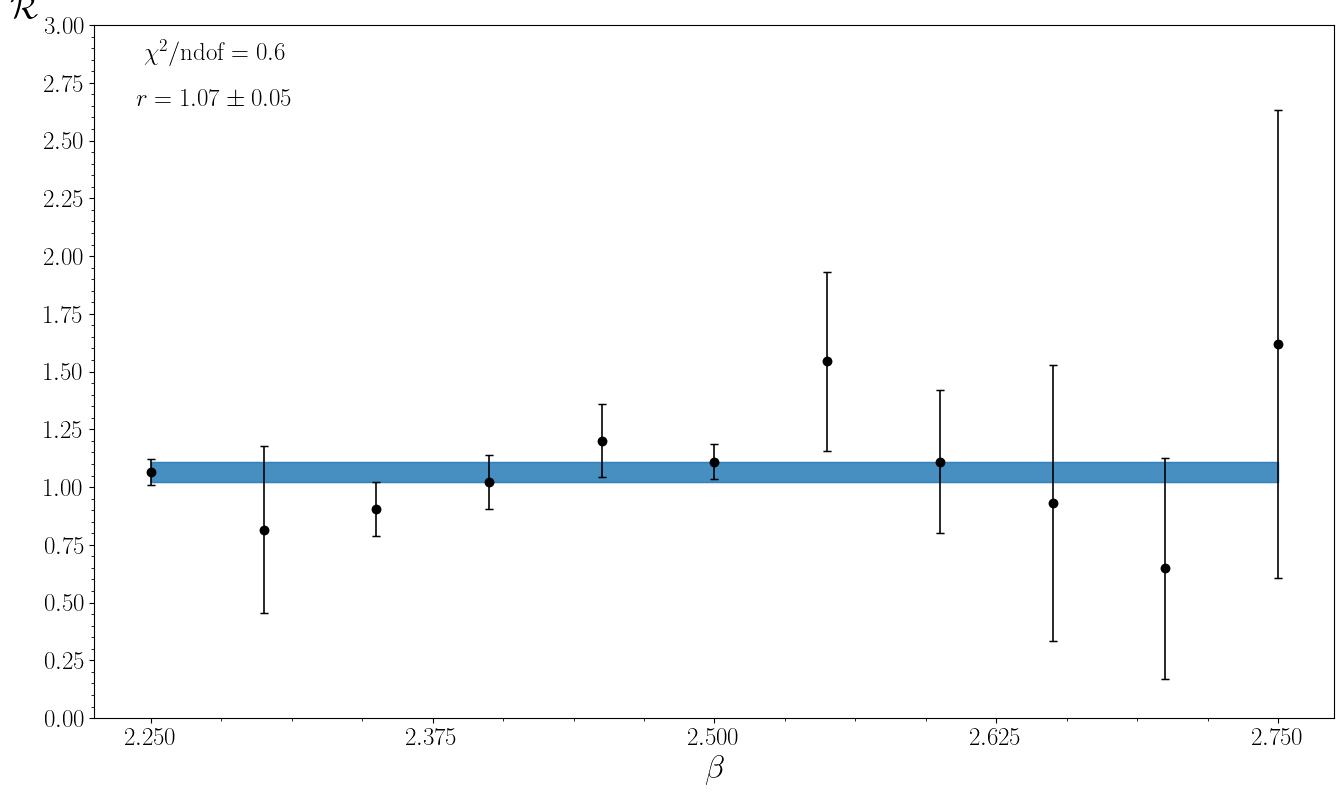

In [ ]:
#Plot sigma for beta
inipars=[[2]]
variants=[['c']]

dini=1
dstop=11
dmindata=8
dfin=100

model=line_np
datatytep="log"


data_y   = []
data_err = []

for k in range(len(xirun[1])):
    for j in range(len(betarun[1])):
        data_y.append(data_f[1][0][j]/signorm)
        data_err.append(edata_f[1][0][j]/signorm)

lt=len(data_y)
data_t   = betax[1]


data_cov = np.zeros((lt,lt))
for i in range(lt):
    data_cov[i,i]=data_err[i]**2

model='line_np'
datatype='ratio'


m=Modelsmin( data_t, data_y, data_cov, dini, dstop, dmindata, dfin, inipars, model, variants, datatype, mcalls, mtol, reuse, inv_first, 10, cov_freeze, improve,100,no_corrs,no_valid_check)

mf=m.minimize()
AIC_list=AIClist(mf[1])

data_tf  = np.linspace(data_t[0],data_t[-1], 1000*lt)

pars=np.array(AIC_list.selval0()[0])
epars=np.array(AIC_list.selval0()[1])

mapars=np.array(AIC_list.avgval0()[0])
emapars=np.array(AIC_list.avgval0()[1])

bf_data_t=data_t[int(AIC_list.ordered()[0][1])-1:int(AIC_list.ordered()[0][2])]
bf_data_y=data_y[int(AIC_list.ordered()[0][1])-1:int(AIC_list.ordered()[0][2])]
bf_data_err=data_err[int(AIC_list.ordered()[0][1])-1:int(AIC_list.ordered()[0][2])]


plt.figure(figsize=(16,9))
plt.errorbar(data_t, data_y, data_err, fmt="ok", alpha=0.3)
plt.errorbar(bf_data_t, bf_data_y, bf_data_err, fmt="ok")

plt.fill_between(bf_data_t, mapars+emapars, mapars-emapars,color=jpac_blue,alpha=0.8)
plt.fill_between(data_tf, mapars+emapars, mapars-emapars,color=jpac_blue,alpha=0.1)
#plt.fill_between(data_tf, pars+epars, pars-epars,color='tab:gray',alpha=0.8)


plt.figtext(0.2, 0.85, 
            '$\\chi^2/\\text{{ndof}}={:.1f}$'.format(AIC_list.ordered()[0,4][0]), 
            horizontalalignment ="center",  
            verticalalignment ="center",  
            wrap = True, fontsize = 18,  
            color ="black")
plt.figtext(0.2, 0.8, 
            '$r={:.2f}\\pm{:.2f}$'.format(mapars,emapars), 
            horizontalalignment ="center",  
            verticalalignment ="center",  
            wrap = True, fontsize = 18,  
            color ="black")
plt.ylabel('$\\mathcal{{R}}$',fontsize=24,rotation=0,loc='top')
plt.xlabel("$\\beta$",fontsize=24)
plt.xticks(np.linspace(data_t[0],data_t[-1],5),fontsize=18)
plt.yticks(np.linspace(0,3,13),fontsize=18)
plt.ylim(0,3)
plt.savefig('../{}/final_{}_{}_sigma_ratio_ti{}_{}_tfin{}_tmin{}_rmin{}_{}_rfin{}_{}.pdf'.format(plotsdir,len(variants_Gc),model_Gc,dini_Gc,dstop_Gc,dfin_Gc,dmindata_Gc,dini_Vr,dstop_Vr,dfin_Vr,corrtype), format="pdf", bbox_inches='tight', pad_inches=0.2)
plt.show()

In [ ]:
# Plot for ratio extrapolated to xi-->infinity
xilen=len(xirun[0])
betalen=len(betarun[0])

inipars=[[2.0,0.],[2.0,0.,0.]]
variants=['linear','quadratic']
model='extrapolate_xi'

datatype='ratio'

dini=1
dstop=0
dmindata=3
dfin=8

data_ratios     = []
data_ratios_err = []
for k in range(xilen):
    data_ratios_int     = []
    data_ratios_err_int = []
    for j in range(betalen):
        avg_Coulomb=data_f[0][k][j]
        avg_Wilson=data_f[1][0][j]
        data_ratios_int.append(avg_Coulomb/avg_Wilson)
        err_Coul=edata_f[0][k][j]
        err_Wilson=edata_f[1][0][j]
        data_ratios_err_int.append(np.sqrt((err_Coul/avg_Wilson)**2+(avg_Coulomb/avg_Wilson**2*err_Wilson)**2))
    data_ratios.append(data_ratios_int)  
    data_ratios_err.append(data_ratios_err_int)

data_ratios   = np.transpose(data_ratios)
data_ratios_err = np.transpose(data_ratios_err)


ratio     = []
ratio_err = []

data_extrapolated     = []
data_extrapolated_err = []
for k in range(betalen):
    data_xi   = np.linspace(1, xilen, xilen)
    data_y   = data_ratios[k]
    data_err  = data_ratios_err[k]
    data_cov = np.zeros((xilen,xilen))
    for i in range(xilen):
        data_cov[i,i]=data_err[i]**2
    
    m=Modelsmin( data_xi, data_y, data_cov, dini, dstop, dmindata, dfin, inipars, model, variants, datatype, mcalls, mtol, reuse, inv_first, 10, cov_freeze, improve,100,no_corrs,no_valid_check)

    mf=m.minimize()
    AIC_list=AIClist(mf[1])

    #pars=np.array(AIC_list.selval0()[0])
    #epars=np.array(AIC_list.selval0()[1])

    data_extrapolated.append(np.array(AIC_list.avgval0()[0]))
    data_extrapolated_err.append(np.array(AIC_list.avgval0()[1]))
    #RepeatSingleFit(data_xi, data_y, data_cov, xi_ini, xi_fin, inipars, funfit , mcalls, mtol,0,1,0,0,5,100)
    #ratio.append(np.array(m.minimize().values[0]))
    #ratio_err.append(np.array(m.minimize().errors[0]))
    #plt.errorbar(data_xi, data_y, data_err, fmt="ok", label="data")
    #plt.plot(data_xi, eval(funfit)(data_xi, *m.minimize().values), label="fit")

<>:71: SyntaxWarning: invalid escape sequence '\,'
<>:71: SyntaxWarning: invalid escape sequence '\,'
/var/folders/6f/lpqhbvqs49j3w6hj241yz3880000gn/T/ipykernel_34869/344342502.py:71: SyntaxWarning: invalid escape sequence '\,'
  plt.errorbar(np.array(bf_data_t)+shift*k, bf_data_y, bf_data_err, fmt="ok",color=jpac_color_around[k],label='$\\xi={},\,\\chi^2/\\text{{ndof}}={:.1f}$'.format(xi,AIC_list.ordered()[0,4][0]))
/var/folders/6f/lpqhbvqs49j3w6hj241yz3880000gn/T/ipykernel_34869/344342502.py:70: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(np.array(data_t)+shift*k, data_y, data_err, fmt="ok", alpha=0.3,color=jpac_color_around[k])
/var/folders/6f/lpqhbvqs49j3w6hj241yz3880000gn/T/ipykernel_34869/344342502.py:71: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take preced

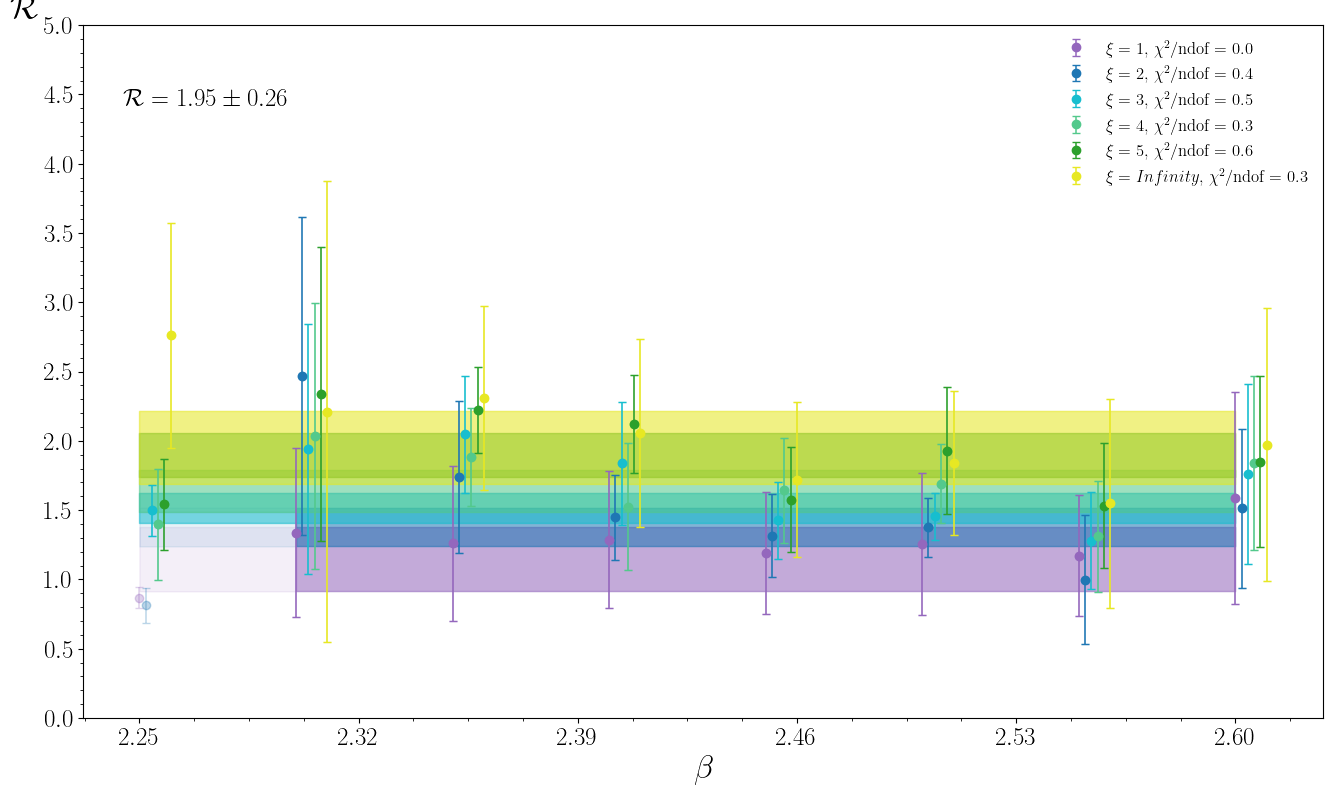

In [ ]:
#Plot sigma for beta
inipars=[[2.0]]
variants=['constant']

dini=1
dstop=7
dmindata=6
dfin=11

model=line_np
datatype='ratio'

plt.figure(figsize=(16,9))

for k in range(xilen+1):

    if (k<xilen):
        xi=k+1
        data_y   = []
        data_err = []    
        for j in range(betalen):
            #data_Coulomb=data_f[0][k][j]
            avg_Coulomb=data_f[0][k][j]#ensemble_stat(data_Coulomb).mean()
            #data_Wilson=data_f[1][0][j]
            avg_Wilson=data_f[1][0][j]#ensemble_stat(data_Wilson).mean()
            data_y.append(avg_Coulomb/avg_Wilson)
            err_Coul=edata_f[0][k][j]#np.sqrt(ensemble_stat(data_Coulomb).cov())
            err_Wilson=edata_f[1][0][j]#np.sqrt(ensemble_stat(data_Wilson).cov())
            data_err.append(np.sqrt((err_Coul/avg_Wilson)**2+(avg_Coulomb/avg_Wilson**2*err_Wilson)**2))
    else:
        xi='Infinity'
        data_y   = data_extrapolated
        data_err = data_extrapolated_err


    lt=len(data_y)

    data_t   = betax[0]


    data_cov = np.zeros((lt,lt))
    for i in range(lt):
        data_cov[i,i]=data_err[i]**2

    model='nb_line_np'
    datatype='ratio'



    m=Modelsmin( data_t, data_y, data_cov, dini, dstop, dmindata, dfin, inipars, model, variants, datatype, mcalls, mtol, reuse, inv_first, 10, cov_freeze, improve,10,no_corrs,no_valid_check)

    mf=m.minimize()
    AIC_list=AIClist(mf[1])

    data_tf  = np.linspace(data_t[0],data_t[-1], 1000*lt)

    pars=np.array(AIC_list.selval0()[0])
    epars=np.array(AIC_list.selval0()[1])

    mapars=np.array(AIC_list.avgval0()[0])
    emapars=np.array(AIC_list.avgval0()[1])

    bf_data_t=data_t[int(AIC_list.ordered()[0][1])-1:int(AIC_list.ordered()[0][2])]
    bf_data_y=data_y[int(AIC_list.ordered()[0][1])-1:int(AIC_list.ordered()[0][2])]
    bf_data_err=data_err[int(AIC_list.ordered()[0][1])-1:int(AIC_list.ordered()[0][2])]

    np.savetxt('../{}/ratio_xi={}.dat'.format(resultsdir,k+1), np.transpose([data_y, data_err]))

    shift=0.002
    plt.errorbar(np.array(data_t)+shift*k, data_y, data_err, fmt="ok", alpha=0.3,color=jpac_color_around[k])
    plt.errorbar(np.array(bf_data_t)+shift*k, bf_data_y, bf_data_err, fmt="ok",color=jpac_color_around[k],label='$\\xi={},\,\\chi^2/\\text{{ndof}}={:.1f}$'.format(xi,AIC_list.ordered()[0,4][0]))
    plt.legend(loc=1)

    plt.fill_between(bf_data_t, mapars+emapars, mapars-emapars,color=jpac_color_around[k],alpha=0.5)
    plt.fill_between(data_tf, mapars+emapars, mapars-emapars,color=jpac_color_around[k],alpha=0.1)
    #plt.fill_between(data_tf, pars+epars, pars-epars,color='tab:gray',alpha=0.8)

    #plt.figtext(0.2, 0.8, 
    #            '$r={:.2f}\\pm{:.2f}$'.format(mapars,emapars), 
    #            horizontalalignment ="center",  
    #            verticalalignment ="center",  
    #            wrap = True, fontsize = 18,  
    #            color =jpac_color_around[k])
    plt.ylabel('$\\mathcal{{R}}$',fontsize=24,rotation=0,loc='top')
    plt.xlabel("$\\beta$",fontsize=24)

plt.figtext(0.15, 0.8, 
'$\\mathcal{{R}}={:.2f}\\pm{:.2f}$'.format(mapars,emapars), 
horizontalalignment ="left",  
verticalalignment ="center",  
wrap = True, fontsize = 18,  
color ="black")

plt.legend(fontsize=12,frameon=False,loc=0)
plt.xticks(np.linspace(data_t[0],data_t[-1],6),fontsize=18)
plt.yticks(np.linspace(0,5,11),fontsize=18)
plt.ylim(0,5)
plt.savefig('../{}/final_{}_{}_sigma_ratio_ti{}_{}_tfin{}_tmin{}_rmin{}_{}_rfin{}_nocorrs={}_{}.pdf'.format(plotsdir,len(variants_Gc),model_Gc,dini_Gc,dstop_Gc,dfin_Gc,dmindata_Gc,dini_Vr,dstop_Vr,dfin_Vr,no_corrs,corrtype), format="pdf", bbox_inches='tight', pad_inches=0.2)
plt.show()

In [ ]:
#Plot sigma for beta
inipars=[[2]]
variants=[['c']]

dini=1
dstop=11
dmindata=8
dfin=100

model=line_np
datatytep="log"

plt.figure(figsize=(16,9))

for k in range(4):

    data_y   = []
    data_err = []

    
    for j in range(len(betarun)):
        data_jackk=ensemble_stat(jackknife(jackknife(jackknife(data_f[0][k][j][0:len(data_f[1][0][j])]*als[k][j]**2).sample()).up()).up())
        data_y.append(data_jackk.mean()[0])
        data_err.append(np.sqrt(data_jackk.rcov()))

    lt=len(data_y)
    data_t   = betax[0]


    data_cov = np.zeros((lt,lt))
    for i in range(lt):
        data_cov[i,i]=data_err[i]**2

    #model='line_np'
    #datatype='ratio'



    #m=Modelsmin( data_t, data_y, data_cov, dini, dstop, dmindata, dfin, inipars, model, variants, datatype, mcalls, mtol, reuse, inv_first, 0, 0, improve,100)

    #mf=m.minimize()
    #AIC_list=AIClist(mf[1])

    data_tf  = np.linspace(data_t[0],data_t[-1], 1000*lt)

    #pars=np.array(AIC_list.selval0()[0])
    #epars=np.array(AIC_list.selval0()[1])

    #mapars=np.array(AIC_list.avgval0()[0])
    #emapars=np.array(AIC_list.avgval0()[1])

    bf_data_t=data_t[int(AIC_list.ordered()[0][1])-1:int(AIC_list.ordered()[0][2])]
    bf_data_y=data_y[int(AIC_list.ordered()[0][1])-1:int(AIC_list.ordered()[0][2])]
    bf_data_err=data_err[int(AIC_list.ordered()[0][1])-1:int(AIC_list.ordered()[0][2])]


    plt.errorbar(data_t, data_y, data_err, fmt="ok", alpha=0.8,color=jpac_color_around[k])
    #plt.errorbar(bf_data_t, bf_data_y, bf_data_err, fmt="ok",color=jpac_color_around[k])
#                 ,label='$\\chi^2/\\text{{ndof}}={:.1f}$'.format(AIC_list.ordered()[0,4][0]))

    #plt.fill_between(bf_data_t, mapars+emapars, mapars-emapars,color=jpac_color_around[k],alpha=0.8)
    #plt.fill_between(data_tf, mapars+emapars, mapars-emapars,color=jpac_color_around[k],alpha=0.1)
    #plt.fill_between(data_tf, pars+epars, pars-epars,color='tab:gray',alpha=0.8)


    #plt.figtext(0.2, 0.85, 
    #            '$\\chi^2/\\text{{ndof}}={:.1f}$'.format(AIC_list.ordered()[0,4][0]), 
    #            horizontalalignment ="center",  
    #            verticalalignment ="center",  
    #            wrap = True, fontsize = 18,  
    #            color ="black")
    #plt.figtext(0.2, 0.8, 
    #            '$r={:.2f}\\pm{:.2f}$'.format(mapars,emapars), 
    #            horizontalalignment ="center",  
    #            verticalalignment ="center",  
    #            wrap = True, fontsize = 18,  
    #            color =jpac_color_around[k])
    plt.ylabel('$a^2\\sigma$',fontsize=24,rotation=0,loc='top')
    plt.xlabel("$\\beta$",fontsize=24)

plt.legend(fontsize=12,frameon=False,loc=0)
plt.xticks(np.linspace(data_t[0],data_t[-1],5),fontsize=18)
plt.yticks(np.linspace(0,3,13),fontsize=18)
plt.yscale('log')
plt.ylim(0,1)
plt.savefig('../{}/final_{}_{}_sigma_ratio_ti{}_{}_tfin{}_tmin{}_rmin{}_{}_rfin{}_{}.pdf'.format(plotsdir,len(variants_Gc),model_Gc,dini_Gc,dstop_Gc,dfin_Gc,dmindata_Gc,dini_Vr,dstop_Vr,dfin_Vr,corrtype), format="pdf", bbox_inches='tight', pad_inches=0.2)
plt.show()

TypeError: object of type 'numpy.float64' has no len()

<Figure size 1600x900 with 0 Axes>